# Comparing Tautomer Generation Algorithms

[Tautomers](https://en.wikipedia.org/wiki/Tautomer) are structures that can interconvert under given conditions. For example, ___. Cheminformatics packages have algorithms to generate tautomers based on rules. This post compares their results to each other and to experimentally-observed tautomers.

All of the tautomer generation algorithms discussed below are based on rules from Markus Sitzmann, Wolf-Dietrich Ihlenfeldt, and Marc C. Nicklaus, “Tautomerism in Large Databases”, JCAMD 24:521 (2010) https://doi.org/10.1007/s10822-010-9346-4.

RDKit has two tautomer generation algorithms, [GetV1TautomerEnumerator](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html#rdkit.Chem.MolStandardize.rdMolStandardize.GetV1TautomerEnumerator) and the [new algorithm, TautomerEnumerator](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html#rdkit.Chem.MolStandardize.rdMolStandardize.TautomerEnumerator). The [2022.03 release notes](https://www.rdkit.org/docs/BackwardsIncompatibleChanges.html#tautomer-enumeration-improvements) state:
> The rules for tautomer enumeration in MolStandardize have been updated to more closely match the rules in the original publication. These changes primarily consist of making the rules more specific; the consequence is that less tautomers will be generated with this version.

but maintainer Greg Landrum [wrote](https://github.com/rdkit/rdkit/discussions/6997#discussioncomment-7893160)
> That's [the new TautomerEnumerator returning fewer examples than the previous rules V1] not something I've noticed. The code change adds a missed case to the enumeration rule set, so at first glance you'd expect it to always produce more tautomers, but I suppose that could still result in a smaller number of tautomers in the end because of how the transformations interact with each other.

So one purpose of this blog post is to empirically answer the question of whether the new RDKit algorithm produces more or fewer tautomers than the V1 algorithm.

NIH [CADD Group Chemoinformatics Tools and User Services (CACTUS)](https://cactus.nci.nih.gov/) also has algorithms that can be run on a [Tautomerizer web page](https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl) or with the package [CACTVS](https://www.cactvs.com/academic/) from Xemistry GmbH. Marc Niclaus notes that CACTVS has "many additional transforms vs. the ones we used in 2010 [for the paper cited above]. This now includes numerous ring-chain and valence tautomerism rules, for a total of 119 rules" (private communication). We compare these two NIH algorithms to the new RDKit algorithm. Because I couldn't install it on my computer due to CPU compatibility, I used the web site which has 86 rules, and Marc kindly ran CACTVS on his computer for a few structures using "exhaustive multi-step enumeration iteratively with all rules, until no more new tautomer is found (with a limit of 1,000 attempts)".

To empirically compare these algorithms, we need a set of molecules which have tautomers: Many molecules will not have any tautomers. Nicklaus and team also created [Tautomer Structures Extracted from Experimental Literature](https://cactus.nci.nih.gov/download/tautomer/), with 
> 5,977 structures extracted from experimental literature representing 2,819 cases of tautomeric tuples (mostly tautomer pairs but also a few triples and higher-order tuples). Note that the number of structurally different tuples is only 1,776 (comprising 3,884 different structures) since some tuples are differentiated from each other only by experimental conditions such as solvent, spectroscopy method, etc.

We use release 3 in Excel format, specifically [Tautomer_database_release_3a.xlsx](https://cactus.nci.nih.gov/download/tautomer/Tautomer_database_release_3a.xlsx).

## Code foundation

In [1]:
from typing import Iterable, Callable
from collections import Counter
import statistics
from statistics import StatisticsError

In [2]:
from rdkit.Chem import AllChem as Chem
from rdkit import RDLogger
from rdkit.Chem import Draw, rdFMCS
import rdkit
from rdkit.Chem import Mol
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [3]:
print(rdkit.__version__)
# Suppress RDKit warnings so it doesn't warn about SMILES that produce molecules which violate a rule,
# which would produce many warnings as we produce thousands of molecules
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

2023.09.1


## Enumerating tautomers using RDKit

To use each of RDKit's two tautomer enumerator functions, we put the class for each in a list. Each has the method `.Enumerate` so we can call them with the same code.

In [4]:
def enumerate_tauts(sml):
    # List the tautomer enumerators in RDKit
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]

    # Create a list of dictionaries, one for each tautomer enumerator
    smls_tauts = [{} for enumerator in enumerators]

    # Here Python's enumerate() function may cause confusion with tautomer enumerators! :-)
    for i, enumerator in enumerate(enumerators):
        mol = mol_from_sml(sml)
        tauts = enumerator.Enumerate(mol)
        # Add each tautomer to that enumerator's dictionary as SMILES:mol
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [5]:
#? Delete?
def check_same_keys(dict_list):
    # Check if the list is empty or has only one dictionary
    if len(dict_list) < 2:
        return True

    # Get the keys of the first dictionary in the list
    reference_keys = set(dict_list[0].keys())

    # Iterate through the dictionaries starting from the second one
    for dictionary in dict_list[1:]:
        # Check if the keys of each dictionary match the keys of the reference dictionary
        if set(dictionary.keys()) != reference_keys:
            # Return False if keys are not the same
            return False
    return True

## Preparing the data from the tautomer database

In [6]:
# Tautomer database from https://cactus.nci.nih.gov/download/tautomer/
file_name = "../data/Tautomer_database_release_3a.xlsx"

# If you want to use only the first row for quicker debugging, use this file instead
# file_name = "../data/Tautomer_database_release_3a_first.xlsx"

# The name of the sheet to process
sheet_name = "Tautomer_database"

In [7]:
def canon_sml_or_none(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [8]:
def mol_from_sml(sml: str) -> Mol:
    """Create an RDKit molecule from a SMILES string.
    RDKit cannot create molecules from some SMILES strings if it tries to sanitize them,
    but can if it does not sanitize them.
    It is preferable to sanitize molecules if possible because that does things such as
    delocalize aromatic bonds (instead of alternating single and double bonds),
    which makes different structures (single-double vs. double-single bond sequence) give the same molecule.

    :param sml: SMILES string
    """
    # Try sanitizing molecule first
    mol = Chem.MolFromSmiles(sml, sanitize=True)
    if mol is not None:
        return mol
    # If sanitization fails, turn it off and try creating molecule again
    mol = Chem.MolFromSmiles(sml, sanitize=False)
    return mol

We start by reading the data from the sheet in the Excel file of the tautomer database.

In [9]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_csv_options={"infer_schema_length":10000},
    )

It turns out that the last row is all null values:

In [10]:
df.tail(1)

Ref,Size,Solvent,Solvent_Proportion,Solvent_Mixture,Temperature,pH,Experimental_Method,Entry_ID1,Type_1,ID_Hash_1,FICTS_1,HASHISY_1,FICuS_1,TAUTOHASH_1,uuuuu_1,Std_InChIKey_1,Std_InChI_1,SMILES_1,Mol_Formula_1,Mol_Weight_1,IUPAC_Name_1,Quantitative_ratio_1,Qualitative_prevalence_1,Prevalence_Category_1,Filename_1,Publication_DOI_1,Publication_ID_1,Authors_1,Affiliation_1,Title_1,Section_1,Page_Number(s)_1,Notes_1,Cmpd_Number_1,Entry_ID2,Type_2,…,Publication_DOI_4,Publication_ID_4,Authors_4,Affiliation_4,Title_4,Section_4,Page_Number(s)_4,Notes_4,Cmpd_Number_4,Entry_ID5,Type_5,Transf_1_5,ID_Hash_5,FICTS_5,HASHISY_5,FICuS_5,TAUTOHASH_5,uuuuu_5,Std_InChIKey_5,Std_InChI_5,SMILES_5,Mol_Formula_5,Mol_Weight_5,IUPAC_Name_5,Quantitative_ratio_5,Qualitative_Prevalence_5,Prevalence_Category_5,Filename_5,Publication_DOI_5,Publication_ID_5,Authors_5,Affiliation_5,Title_5,Section_5,Page_Number(s)_5,Notes_5,Cmpd_Number_5
i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,i64,str,str
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


so let's delete it

In [11]:
df = df.filter(pl.col("Ref").is_not_null())

And we get the 2,819 cases cited in the data documentation.

In [12]:
df.shape

(2819, 147)

In [13]:
# Lists for names of SMILES_n and InChI_n columns
SMILES_columns = [col for col in df.columns if col.startswith('SMILES_')]

#? Delete? Want to use InChI in any way?
InChI_columns = [col for col in df.columns if col.startswith('Std_InChI_')]

# Combined list of SMILES_n and InChI_n columns
numbered_columns = [elem for pair in zip(SMILES_columns, InChI_columns) for elem in pair]

#? Need Size column? Seems like we don't use it.
# Select relevant columns in dataframe
df = df.select("Ref",*numbered_columns)

In [14]:
df

Ref,SMILES_1,Std_InChI_1,SMILES_2,Std_InChI_2,SMILES_3,Std_InChI_3,SMILES_4,Std_InChI_4,SMILES_5,Std_InChI_5
i64,str,str,str,str,str,str,str,str,str,str
1,"""O=C(C)CC(C)=O""","""InChI=1S/C5H8O…","""O/C(C)=C\C(C)=…","""InChI=1S/C5H8O…",null,null,null,null,null,null
2,"""N1=CC=N[NH]1""","""InChI=1S/C2H3N…","""[NH]1N=NC=C1""","""InChI=1S/C2H3N…",null,null,null,null,null,null
3,"""CC1=CC=NN1""","""InChI=1S/C4H6N…","""CC1=NNC=C1""","""InChI=1S/C4H6N…",null,null,null,null,null,null
4,"""N=N=NC1=NNC2=C…","""InChI=1S/C7H6N…","""N=N=NC1=C2C=CC…","""InChI=1S/C7H6N…",null,null,null,null,null,null
5,"""CC1([C@H]2C(C=…","""InChI=1S/C11H1…","""CC1([C@H](CC[C…","""InChI=1S/C11H1…","""CC1([C@H](CC[C…","""InChI=1S/C11H1…",null,null,null,null
6,"""OC(C=CC=C1)=C1…","""InChI=1S/C19H1…","""OC(C=CC=C1)=C1…","""InChI=1S/C19H1…","""OC(C=CC=C1)=C1…","""InChI=1S/C19H1…",null,null,null,null
7,"""O=C(C([H])([H]…","""InChI=1S/C10H1…","""O/C(C1=CC=CC=C…","""InChI=1S/C10H1…","""O=C(/C=C(O)/C)…","""InChI=1S/C10H1…",null,null,null,null
8,"""O/C(C1=CC=CC=C…","""InChI=1S/C15H1…","""O=C(C1=CC=CC=C…","""InChI=1S/C15H1…",null,null,null,null,null,null
9,"""OC1=C(C2=CC=CC…","""InChI=1S/C17H1…","""O=C1C=CC2=CC=C…","""InChI=1S/C17H1…",null,null,null,null,null,null


The Excel sheet has sets of columns for each of up to five experimentally-observed structures for a tautomer, called a Ref in the sheet, in a row. We will use the experimentally-observed structures as inputs to the tautomer generation algorithms, so we [melt](https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.melt.html#polars.DataFrame.melt) the dataframe by making each Ref-structure pair into its own row.

In [15]:
# Melt dataframe: Break out each row's SMILES_n columns into its own row
df_melted = df.melt(id_vars=["Ref"], value_vars=SMILES_columns, value_name="sml")

This produces 2,819 * 5 = 14,095 rows:

In [16]:
df_melted

Ref,variable,sml
i64,str,str
1,"""SMILES_1""","""O=C(C)CC(C)=O"""
2,"""SMILES_1""","""N1=CC=N[NH]1"""
3,"""SMILES_1""","""CC1=CC=NN1"""
4,"""SMILES_1""","""N=N=NC1=NNC2=C…"
5,"""SMILES_1""","""CC1([C@H]2C(C=…"
6,"""SMILES_1""","""OC(C=CC=C1)=C1…"
7,"""SMILES_1""","""O=C(C([H])([H]…"
8,"""SMILES_1""","""O/C(C1=CC=CC=C…"
9,"""SMILES_1""","""OC1=C(C2=CC=CC…"


Because many rows of the Excel sheet have less than five structures, there are many rows with no structure (SMILES), so let's remove those rows. We also don't need to know which number SMILES (1-5) each was, so we'll drop the `variable` columns that Polars created when we melted the original dataframe.

In [17]:
# Keep rows where SMILES is supplied
df_melted = df_melted.filter(pl.col('sml').is_not_null())

# Remove SMILES_n column (n = 1-5)
df_melted = df_melted.drop("variable")

A check of the dataframe confirms that it contains the 5,977 structures reported by the [data description](https://cactus.nci.nih.gov/download/tautomer/).

In [18]:
df_melted

Ref,sml
i64,str
1,"""O=C(C)CC(C)=O"""
2,"""N1=CC=N[NH]1"""
3,"""CC1=CC=NN1"""
4,"""N=N=NC1=NNC2=C…"
5,"""CC1([C@H]2C(C=…"
6,"""OC(C=CC=C1)=C1…"
7,"""O=C(C([H])([H]…"
8,"""O/C(C1=CC=CC=C…"
9,"""OC1=C(C2=CC=CC…"


Next we'll remove duplicate rows, which are possible because a Ref can have multiple rows in the Excel sheet, and those rows may well have some of the same structures.

In [19]:
# Remove duplicate rows
df_melted = df_melted.unique()

This gives us 3,911 different structures. Compared to the 3,884 reported in the data description, this is slightly greater, by 27 or 0.7%. We'll discuss this below.

In [20]:
df_melted

Ref,sml
i64,str
3,"""CC1=CC=NN1"""
7,"""O=C(C([H])([H]…"
12,"""O=C1C=CC2=CC=C…"
15,"""OC1=C(C2=CC=CC…"
18,"""OC1=C(C=CN=C1)…"
40,"""O=[N+](C1=CC=C…"
41,"""O=[N+](C1=CC=C…"
45,"""OC1=NNC(C(OCC)…"
46,"""O=C(N(N1)C2=CC…"


In [21]:
# Remove the input SMILES column; drop rows with any null values, though there are none
df_melted = df_melted.drop_nulls()

In [22]:
df_melted.shape

(3911, 2)

In [23]:
df_melted

Ref,sml
i64,str
3,"""CC1=CC=NN1"""
7,"""O=C(C([H])([H]…"
12,"""O=C1C=CC2=CC=C…"
15,"""OC1=C(C2=CC=CC…"
18,"""OC1=C(C=CN=C1)…"
40,"""O=[N+](C1=CC=C…"
41,"""O=[N+](C1=CC=C…"
45,"""OC1=NNC(C(OCC)…"
46,"""O=C(N(N1)C2=CC…"


Another level of redundancy is that some structures which have different SMILES are actually the same molecule. A way to check if two SMILES correspond to the same molecule is to make each into an RDKit molecule, then output their canonical SMILES, then check if those are the same.

We define `mol_from_sml()` to create RDKit molecules with two methods:
1) preferably, with sanitization
2) as a fallback, without sanitization

Without falling back to `sanitize=False`, eight rows comprising three Ref values (4, 355, and 1130) are not made into molecules, which prevents them from being processed with the steps that follow. Including the fallback option allows all rows to be made into molecules.

In [24]:
# Add the RDKit molecule
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(lambda s: mol_from_sml(s)).alias("mol"),
    ]
)

# Add the canonical SMILES
df_melted = df_melted.with_columns(
    [
        pl.col("mol").map_elements(lambda m: canon_sml_or_none(m)).alias("canon_sml"),
    ]
)

# Now that we have canonical SMILES, drop the original SMILES
df_melted = df_melted.drop("sml")

In [25]:
df_melted

Ref,mol,canon_sml
i64,object,str
3,<rdkit.Chem.rdchem.Mol object at 0x16e35f680>,"""Cc1ccn[nH]1"""
7,<rdkit.Chem.rdchem.Mol object at 0x16e35f6f0>,"""CC(=O)CC(=O)c1…"
12,<rdkit.Chem.rdchem.Mol object at 0x16e35f760>,"""COc1ccc(N/C=C2…"
15,<rdkit.Chem.rdchem.Mol object at 0x16e35f7d0>,"""Oc1ccc2ccccc2c…"
18,<rdkit.Chem.rdchem.Mol object at 0x16e35f840>,"""Oc1cnccc1/C=N/…"
40,<rdkit.Chem.rdchem.Mol object at 0x16e35f8b0>,"""O=C1CC(c2ccccc…"
41,<rdkit.Chem.rdchem.Mol object at 0x16e35f990>,"""Cc1cc(=O)n(-c2…"
45,<rdkit.Chem.rdchem.Mol object at 0x16e35fa00>,"""CCOC(=O)c1cc(O…"
46,<rdkit.Chem.rdchem.Mol object at 0x16e35fa70>,"""Cc1cc(=O)n(-c2…"


In [26]:
# Drop duplicate (Ref + canonical SMILES) rows
df_melted = df_melted.unique(["Ref", "canon_sml"])

df_melted = df_melted.sort(["Ref", "canon_sml"])

After removing those duplicates, we have 3,797 different structures:

In [27]:
df_melted.shape

(3797, 3)

Whereas we originally had slightly more than the reported 3,884 data structures, we now have slightly fewer (87 or 2.2%). This is likely due to the definition of "different". Again, we should not count as different structures where SMILES writes an aromatic ring coded with single bonds at odd bond indexes (and double bonds at even bond indexes) is the same as one coded with single bonds at even bond indexes (and double bonds at odd bond indexes). Modifying the [example from Richard L. Apodaca](https://depth-first.com/articles/2020/02/10/a-comprehensive-treatment-of-aromaticity-in-the-smiles-language/), if we don't sanitize these two alternate SMILES for 1,2-bromobenzene, we get different structures and canonical SMILES because they are represented in Kekulé form:

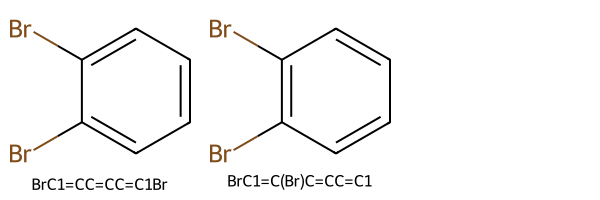

In [28]:
smls_aromatic_equivalent = ["C1=C(Br)C(Br)=CC=C1", "C1C(Br)=C(Br)C=CC=1"]
mols_aromatic_equivalent_unsanitized = [Chem.MolFromSmiles(sml, sanitize=False) for sml in smls_aromatic_equivalent]
canon_smls_aromatic_equivalent_unsanitized = [Chem.MolToSmiles(mol) for mol in mols_aromatic_equivalent_unsanitized]
Draw.MolsToGridImage(mols_aromatic_equivalent_unsanitized, legends=canon_smls_aromatic_equivalent_unsanitized)

whereas if we do sanitize them, we get the same structure and canonical SMILES:

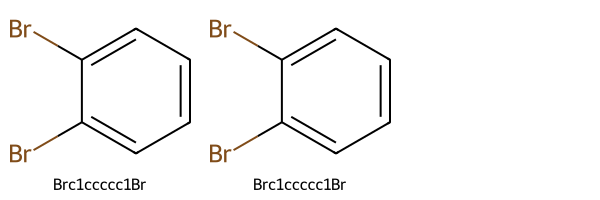

In [29]:
mols_aromatic_equivalent_sanitized = [Chem.MolFromSmiles(sml, sanitize=True) for sml in smls_aromatic_equivalent]
canon_smls_aromatic_equivalent_sanitized = [Chem.MolToSmiles(mol) for mol in mols_aromatic_equivalent_sanitized]
Draw.MolsToGridImage(mols_aromatic_equivalent_sanitized, legends=canon_smls_aromatic_equivalent_sanitized)

So the slight differences in the number of different structures as determined by RDKit compared to the tool used by Nicklaus and team (presumably their CACTUS tool) is probably due to the algorithms used to determine the molecular graph (from the input SMILES or other identifier) and then the canonical SMILES. Inspection by multiple chemists of individual pairs would probably lead to better agreement of whether two similar structures are different, but the automatic adjudication required for large datasets is undoubtedly challenging to encode in an algorithm.

In [30]:
#? Keep this function?
def smls_tauts(
        enumerator: Callable,
        mol: Mol,
    ) -> dict[str, Mol]:
    """Use a tautomer enumerator to find the tautomers for a given molecule
    
    :param enumerator: The tautomer enumerator class, which has an Enumerate method
    :param mol: An RDKit molecule
    :returns: A dictionary of SMILES:mol entries
    """
    tauts = enumerator.Enumerate(mol)
    tauts_dict = dict()
    for taut in tauts:
        tauts_dict.update({Chem.MolToSmiles(taut):taut})
    return tauts_dict

In [31]:
def tauts_as_sml_list(
        enumerator: Callable,
        mol: Mol,
    ) -> list[str]:
    """Use a tautomer enumerator to find the tautomers for a given molecule
    
    :param enumerator: The tautomer enumerator class, which has an Enumerate method
    :param mol: An RDKit molecule
    :returns: A list of SMILES
    """
    tauts = enumerator.Enumerate(mol)
    tauts_as_sml_list = []
    for taut in tauts:
        tauts_as_sml_list.append(Chem.MolToSmiles(taut))
    
    # Make smls into a set to remove duplicates, then back into a list so can be in dataframe
    tauts_as_sml_list = list(set(tauts_as_sml_list))
    return tauts_as_sml_list

In [32]:
# Enumerate tautomers--this may take more than one minute
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("mol").map_elements(lambda m: tauts_as_sml_list(enumerator(), m)).alias("tauts" + enumerator.__name__),
        ]
    )

In [33]:
# Manually list tautomers created by NIH Tautomerizer
# https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl
# Settings:
#   steps: multi
#   Predicted tautomers by: All Rules
nih_sml_tauts = {
    "COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O": [
        "COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O",
        "COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C([C@H](C)O)C(=C1C(=C23)C4=C56)[C@H](C)O)OC)O)O)OC)OC)O)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC3=C2[C@H]([C@@H](C1=C(OC)C(=C6C5=C1C2=C4C(=C3O)C(C=C(C4=C5C(=CC6=O)OC)OC)=O)O)[C@H](C)O)[C@H](C)O",
        "COC2=C3[C@H]([C@@H](C4=C(OC)C(=O)C6=C5C(=C1C(C(=C(C=C1OC)O)C2=O)C3=C45)C(=CC6=O)OC)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5=C3C1=C2C(=C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5C3=C1C2=C(C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
    ],
    "CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1": [
        "CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=N2)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=C)N2",
        "CSC1=NC(C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)=C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(=C(O)OC(C)C)C(=N2)C",
        "CSC1NC(=C(C(=N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(=C1C(C=CC=C1)=[N+]([O-])O)C(=C(C)N2)C(=O)OC(C)C",
        "CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C",
    ],
    # 1704 a
    "Cc1cc(C=O)c(C)c(C=O)c1": [
        "CC1=CC(C(C(=C1)C=O)=C)=CO",
        "C[CH]1C=C([C](C(=C1)C=O)=[CH2])C=O",
    ],
    # 1704 b
    "C=c1c(C=O)cc(C)cc1=CO": [
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
        "C=C1C(C=C(C=C1C=O)C)C=O",
        "C=C1C(=CC(=CC1C=O)C)C=O",
        "[CH2]=[C]1C(=C[CH](C=C1C=O)C)C=O",
        "CC1=C(C=C(C=C1C=O)C)C=O",
    ],
    # 890a
    "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54": [
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2C(C=C(C(=C12)C5=C3C(C4=O)C(=O)C=C5OC)OC)=O)=O)OC)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(C2=C(C=C(C(=C12)C4=C3C(=C(O)C=C4OC)C5=O)OC)O)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC6=C(O)C1=C(O)C=C(OC)C2=C1C(=C3C(=C(C(=C4C(C=C(C2=C34)OC)=O)O)OC)C[C@H](C)OC(=O)C5=CC=C(C=C5)O)C6=C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC5=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C4=C(CC(C(=C34)C5=O)=O)OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(C2=C1C(=C(OC)CC2=O)C5=C3C(=C4O)C(=O)C=C5OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(C(=C(C2=C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)O)O)OC)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC4=C(C3=C1C(=C(C(=C2C(C=C(C(=C12)C5=C3C(=C4O)C(=O)C=C5OC)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC2=C(C3=C1C(=C(C(C5=C1C(=C4C(=CC(C(=C2O)C34)=O)OC)C(=CC5=O)OC)=O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
        "COC3=C(C1=C4C(=C(C(=C5C(C=C(C(=C2C(=CC(C(=C12)C3=O)=O)OC)C45)OC)=O)O)OC)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)C[C@@H](C)OC(=O)C7=CC=CC=C7",
    ],
    # 890b
    #   3 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
    #   7 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   3 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
    #   6 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    "COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43": [
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(=C(C(C3=C45)=C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)O)OC)OC)O)C7=O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(C(=C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)O)O",
        "COC5=C(C3=C(C=C(C4=C1C(=CC(=C2C(=C(C(C(=C12)C(=C34)C5=C[C@@H](C)OC(=O)C6=CC=CC=C6)=C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)O)OC)OC)O)O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(C(C=C(C2=C4C(=CC(C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(C=C6)=O)OC)=O)=O)OC)OC)=O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(C5=C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CC=C(C=C6)O)OC)O)=O)OC)OC)O)C7=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(=C6C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC)OC)=O",
        "COC2=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C4=C3C(=C2O)C(C=C(C3=C5C(=CC(C6=C(C(=C(C4=C56)C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)O)=O)OC)OC)=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(O)=C6C=CC(C=C6)=O)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C3=C2C(=C(C=C(C2=C4C(=CC(=C5C(C(=C(C3=C45)C[C@H](C)OC(=O)C6=CCC(=O)C=C6)OC)=O)O)OC)OC)O)C7=O",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(=O)C3=CC=C(C=C3)O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(=O)C7=CC=C(C=C7)O)OC)=O)O)OC",
        "COC7=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C5=C2C4=C(C(C(=C2C[C@H](C)OC(O)=C3C=CC(C=C3)=O)OC)=O)C(=O)C=C(OC)C4=C6C5C(=C(C=C6OC)O)C7=O",
        "COC4=C(C[C@@H](C)OC(=O)C1=CC=CC=C1)C2=C6C5C(=C3C2=C(C(C=C3OC)=O)C4=O)C(=CC(=C5C(C(=C6C[C@H](C)OC(O)=C7C=CC(C=C7)=O)OC)=O)O)OC",
    ],
    # 1688a
    #   1 tautomer(s) generated using PT_03_00 - simple (aliphatic) imine
    #   2 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_16_00 - nitroso/oxime
    #   1 tautomer(s) generated using PT_36_00 - oxime/nitrone: 1,2 H-shift
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    "C=C(/C=[N+](\[O-])C(C)(C)/C(C)=N/O)OCC": [
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(=C)NO)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)N=O)OCC",
        "C=C(\C=[N+](/[O-])C(C)(C)C(C)=[NH+][O-])OCC",
        "C=C(C1N(O)C(C)(C)C(=[N+]1[O-])C)OCC",
    ],
    # 1688b
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_39_00 - nitrone/azoxy or Behrend rearrangement
    #   1 tautomer(s) generated using RC_22_00 - 5_endo_trig: 1,5 H-shift
    "C=C(OCC)C1N(O)C(C)(C)C(C)=[N+]1[O-]": [
        "C=C(OCC)C1[NH+](C(C(N1O)(C)C)=C)[O-]",
        "C=C(OCC)C1=[N+](C(C(N1O)(C)C)C)[O-]",
        "C=C(OCC)C=[N+]([O-])C(C)(C)C(C)=NO",
    ],
    # 1512a
    #   1 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using RC_12_00 - 5_endo_tet or iminophosphorane/benzoxazaphospholine
    "CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1": [
        "CC[P]2(OC1C(=CC(=CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P]2(OC1=C(C=C(CC1=N2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)(CC)C6=CC=CC=C6",
        "CC[P](CC)(C1=CC=CC=C1)=NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O",
    ],
    # 1512b
    #   3 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
    #   1 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
    #   1 tautomer(s) generated using RC_12_00 - 5_endo_tet or iminophosphorane/benzoxazaphospholine
    "CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1": [
        "CC[P](CC)(=NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5",
        "CC=[P](CC)(NC1C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)=O)C5=CC=CC=C5",
        "CC[P](CC)(=NC1=CC(=CC(C(C)(C)C)C1=O)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C5=CC=CC=C5",
        "CC[P]5(CC)(NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O5)C6=CC=CC=C6",
    ],
    # 457a
    "[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(=O)c-3c(O[2H])c2O[2H])cc1O[2H]": [
        # 2 tautomer(s) generated using PT_02_00 - 1,5 (thio)keto/(thio)enol
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=C(OC)C3=O)O[2H])[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        # 9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "O=C1C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)O[2H])O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3(C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])=O)[2H])O[2H]",
        "O([2H])C1(C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])=O)[2H]",
        "O=C1C(C=C(C=C1)C3=C(C(=C2C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)O[2H])O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C3(C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])=O)[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(C(C(=C2O3)[2H])=O)(OC)[2H])=O)[2H])=O)O[2H])O[2H]",
        # 2 tautomer(s) generated using PT_07_00 - 1,5 (aromatic) heteroatom H shift (1)
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2=C(C(=C(C(=C2O3)[2H])O[2H])OC)O[2H])=O)O[2H])O[2H]",
        # 2 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "O=C1C(=CC(=CC1[2H])C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])O[2H]",
        "O([2H])C3=CC=C(C2=C(C(=C1C(C(=C(C(=C1O2)[2H])O[2H])OC)=O)O[2H])O[2H])C(C3=O)[2H]",
        # 1 tautomer(s) generated using PT_11_00 - 1,11 (aromatic) heteroatom H shift
        "O=C1C(=CC(C=C1)=C3C(=C(C2=C(C(=C(C(=C2O3)[2H])O[2H])OC)O[2H])O[2H])O[2H])O[2H]",
        # 1 tautomer(s) generated using PT_11_02 - 1,15 (aromatic) heteroatom H shift
        "O=C1C(=CC(C=C1)=C2C(=C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])O[2H])O[2H])O[2H]",
    ],
    # 457b
    "[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])cc1O[2H]": [
        # 9 tautomer(s) generated using PT_06_00 - 1,3 heteroatom H shift
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(OC)(C3=O)[2H])[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C2(C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)=O)[2H])O[2H]",
        "O([2H])C1(C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])=O)[2H]",
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(=C3O[2H])OC)[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C2=C(C(C3=C(O2)C(=C(O[2H])C(OC)(C3=O)[2H])[2H])=O)O[2H])(O[2H])[2H]",
        "O=C1C(C=C(C=C1)C2(C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)=O)[2H])(O[2H])[2H]",
        "O([2H])C1=C(C=C(C=C1)C2=C(C(C3=C(O2)C([2H])(C(=O)C(OC)(C3=O)[2H])[2H])=O)O[2H])O[2H]",
        # 7 tautomer(s) generated using PT_09_00 - 1,7 (aromatic) heteroatom H shift
        "O=C1C(=CC(=CC1[2H])C2=C(C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O([2H])C3=CC=C(C1=C(C(C2=C(O1)C(=C(O[2H])C(=C2O[2H])OC)[2H])=O)O[2H])C(C3=O)[2H]",
        "O=C1C(=CC(=CC1[2H])C3=C(C(C2(C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)[2H])=O)O[2H])O[2H]",
        "O=C1C(=CC(=CC1[2H])C3=C(C(=C2C(=C(C(C(=C2O3)[2H])=O)OC)O[2H])O[2H])O[2H])O[2H]",
        "O=C1C(=CC(C=C1[2H])=C2C(=C(C3=C(O2)C(=C(O[2H])C(=C3O[2H])OC)[2H])O)O[2H])O[2H]",
        # 1 tautomer(s) generated using PT_10_00 - 1,9 (aromatic) heteroatom H shift
        "O([2H])C1=C(C=C(C=C1)C3=C(C(=C2C(C(=C(C(=C2O3)[2H])O[2H])OC)=O)O[2H])O[2H])O[2H]",
    ],
}

In [34]:
def extract_ref_and_num(
    e_name: str,
):
    parts = e_name.split("_")
    ref_str = parts[1]
    try:
        ref = int(ref_str)
    except:
        ref = None
    num_str = parts[2]
    try:
        num = int(num_str)
    except:
        num = None
    return ref, num

In [35]:
cactvs = Chem.SDMolSupplier('../data/Refs.sdf')
# Set to store all unique property keys
# all_properties = set()

refs_cactvs = []
nums_cactvs = []
tauts_cactvs = []

# Iterate through the molecules in the SDF file
for mol in cactvs:
    if mol is not None:
        # Get all property keys for the current molecule
        # properties = mol.GetPropNames()

        # print(mol.GetProp("E_NAME"), mol.GetProp("E_SMILES"))
        ref, num = extract_ref_and_num(mol.GetProp("E_NAME"))
        sml = mol.GetProp("E_SMILES")
        refs_cactvs.append(ref)
        nums_cactvs.append(num)
        tauts_cactvs.append(sml)
        # print(ref,num, sml)
        # Print property name and value for each property
        # for prop_name in properties:
        #     prop_value = mol.GetProp(prop_name)
            # print(f"Molecule Property: {prop_name}, Value: {prop_value}")
    # break

# Draw.MolsToGridImage(cactvs)
# print("-------------------")
# zipped = zip(refs_cactvs, nums_cactvs, tauts_cactvs)
# for row in zipped:
#     print(row)

In [36]:
df_cactvs = pl.DataFrame({"ref": refs_cactvs, "num": nums_cactvs, "tautCACTVS": tauts_cactvs})
df_cactvs

ref,num,tautCACTVS
i64,i64,str
890,1,"""COC2C(O)C4C(=O…"
890,1,"""COC2C(O)C4C(=O…"
890,1,"""COC2C(O)C4C(=C…"
890,1,"""COC2C(O)C4C(=O…"
890,1,"""COC2C(O)C4=C(O…"
890,1,"""COC2C(O)C4C(=C…"
890,1,"""COC2C(O)C4=C(O…"
890,1,"""COC2C(O)C4C(=C…"
890,1,"""COC2C(O)C4=C(O…"


In [37]:
matching = {
    890: {
        1: "COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54",
        2: "COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43",
    },
    1512: {
        1: "CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1",
        2: "CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1",
    },
    1704: {
        1: "Cc1cc(C=O)c(C)c(C=O)c1",
        2: "C=c1c(C=O)cc(C)cc1=CO",
    },
}

In [38]:
refs = []
nums = []
input_smls = []
for ref in matching.keys():
    for num, input_sml in matching[ref].items():
        refs.append(ref)
        nums.append(num)
        input_smls.append(input_sml)
df_matching = pl.DataFrame({"canon_sml": input_smls, "ref": refs, "num": nums})
df_matching

canon_sml,ref,num
str,i64,i64
"""COc1c(O)c2c(=O…",890,1
"""COc1c(C[C@@H](…",890,2
"""CCP1(CC)(c2ccc…",1512,1
"""CCP(CC)(=Nc1cc…",1512,2
"""Cc1cc(C=O)c(C)…",1704,1
"""C=c1c(C=O)cc(C…",1704,2


In [39]:
df_cactvs_matching = df_matching.join(df_cactvs, on=['ref', 'num'], how='inner')
df_cactvs_matching

canon_sml,ref,num,tautCACTVS
str,i64,i64,str
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4C(=O…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4C(=O…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4C(=C…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4C(=O…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4=C(O…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4C(=C…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4=C(O…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4C(=C…"
"""COc1c(O)c2c(=O…",890,1,"""COC2C(O)C4=C(O…"


In [40]:
df_cactvs_matching_grouped = df_cactvs_matching.drop(["ref", "num"]).group_by("canon_sml").agg(pl.col("tautCACTVS"))
df_cactvs_matching_grouped

canon_sml,tautCACTVS
str,list[str]
"""CCP(CC)(=Nc1cc…","[""CC[P](CC)(=NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5""]"
"""COc1c(O)c2c(=O…","[""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67"", ""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67)O"", … ""COC2C(O)C4=C(O)CC(OC)C5C6C(OC)C=C(O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67""]"
"""Cc1cc(C=O)c(C)…","[""CC1=CC(=C(C(=C1)C=O)C)C=O"", ""CC1=CC(C(C(=C1)C=O)=C)C=O"", … ""CC1=CC(C(C(=C1)C=O)=C)=CO""]"
"""COc1c(C[C@@H](…","[""COC3C(C[C@@H](C)OC(=O)C1CCCCC1)C4C6C(C[C@H](C)OC(=O)C2CCC(O)CC2)C(OC)C(=O)C7C(O)CC(OC)C(C5C(OC)CC(O)C(C3=O)C45)C67""]"
"""C=c1c(C=O)cc(C…","[""C=C\1C(=CC(=CC1=C\O)C)C=O""]"
"""CCP1(CC)(c2ccc…","[""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", ""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", … ""CC=[P](CC)(C1=CC=CC=C1)N=C2CC(=CC(=C2O)C(C)(C)C)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5""]"


In [41]:
# Function to canonicalize a list of SMILES
def canonicalize_smiles(smls_list: list[str]) -> list[str]:
    """
    Canonicalize a list of SMILES, trying first with and then without sanitization;
    convert list into a set to remove duplicates, then back to a list so can go in dataframe

    :param smls_list: List of SMILES strings
    :returns: List of canonical SMILES strings
    """
    canonical_smiles = []
    for sml in smls_list:
        mol = Chem.MolFromSmiles(sml)
        if mol:
            canonical = Chem.MolToSmiles(mol)
            canonical_smiles.append(canonical)
        else:
            mol = Chem.MolFromSmiles(sml, sanitize=False)
            if mol:
                canonical = Chem.MolToSmiles(mol)
                canonical_smiles.append(canonical)
            else:
                canonical_smiles.append(None)
                print("Molecule couldn't be created")
    # Eliminate duplicates by turning list into a set, then back to a list so can go in dataframe
    canonical_smiles_unique = list(set(canonical_smiles))
    return canonical_smiles_unique

In [42]:
df_cactvs_matching_grouped = df_cactvs_matching_grouped.with_columns(
    [
        pl.col("tautCACTVS").apply(lambda l: canonicalize_smiles(l)).alias("tautsCACTVS"),
    ]
)

/var/folders/9w/cn8tqbv976gckxd0c9cbr1sw0000gn/T/ipykernel_33828/2916706968.py:3: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("tautCACTVS").apply(lambda l: canonicalize_smiles(l)).alias("tautsCACTVS"),


In [43]:
# Merge in CACTVS tauts by left-joining on canon_sml

# Ensure no tautsNIH columns already exist--can cause additional column tautsNIH_right to be created
columsCACTVS = [col for col in df_melted.columns if 'CACTVS' in col.upper()]
for col in columsCACTVS:
    df_melted = df_melted.drop(col)
    
df_melted = df_melted.join(df_cactvs_matching_grouped, on="canon_sml", how="left")

# View rows where there are CACTVS tautomers
df_melted.filter(pl.col("Ref").is_in(matching.keys()))

Ref,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS
i64,object,str,list[str],list[str],list[str],list[str]
890,<rdkit.Chem.rdchem.Mol object at 0x179cdeab0>,"""COc1c(C[C@@H](…","[""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c(O)cc(OC)c5c1c23)C(=O)C(OC)C4=C[C@H](C)OC(=O)c1ccc(O)cc1"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c(c(O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c32)C(=O)C=C1OC""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)C3C=CC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21"", … ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""]","[""COC3C(C[C@@H](C)OC(=O)C1CCCCC1)C4C6C(C[C@H](C)OC(=O)C2CCC(O)CC2)C(OC)C(=O)C7C(O)CC(OC)C(C5C(OC)CC(O)C(C3=O)C45)C67""]","[""COC1CC(O)C2C(=O)C(OC)C(C[C@@H](C)OC(=O)C3CCCCC3)C3C4C(C[C@H](C)OC(=O)C5CCC(O)CC5)C(OC)C(=O)C5C(O)CC(OC)C(C1C23)C54""]"
890,<rdkit.Chem.rdchem.Mol object at 0x28ea1e6c0>,"""COc1c(O)c2c(=O…","[""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c(O)cc(OC)c5c1c23)C(=O)C(OC)C4=C[C@H](C)OC(=O)c1ccc(O)cc1"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c(c(O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c32)C(=O)C=C1OC""]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)C3C=CC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21"", … ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""]","[""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67"", ""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67)O"", … ""COC2C(O)C4=C(O)CC(OC)C5C6C(OC)C=C(O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67""]","[""COC1CC(O)=C2C(O)C(OC)C(C[C@@H](C)OC(=O)C3CCCCC3)C3C2C1C1C(OC)CC(O)=C2C(O)C(OC)C(C[C@H](C)OC(=O)C4CCC(O)CC4)C3C21"", ""COC1C=C(O)C2C(O)C(OC)C(C[C@@H](C)OC(=O)C3CCCCC3)C3C4C(C[C@H](C)OC(=O)C5CCC(O)CC5)C(OC)C(O)C5C(=O)CC(OC)C(C1C23)C54"", … ""COC1CC(O)=C2C(O)C(OC)C(C[C@H](C)OC(=O)C3CCC(O)CC3)C3C2C1C1C(OC)CC(=O)C2C(O)C(OC)C(C[C@@H](C)OC(=O)C4CCCCC4)C3C21""]"
1512,<rdkit.Chem.rdchem.Mol object at 0x28ea39a10>,"""CCP(CC)(=Nc1cc…","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP(CC)(=NC1C=C(C(c2ccccc2)(c2ccccc2)c2ccccc2)C=C(C(C)(C)C)C1=O)c1ccccc1""]","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1""]","[""CC[P](CC)(=NC1=C(C(=CC(=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)C(C)(C)C)O)C5=CC=CC=C5""]","[""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1""]"
1512,<rdkit.Chem.rdchem.Mol object at 0x28ea252a0>,"""CCP1(CC)(c2ccc…","[""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1""]","[""CCP1(CC)(c2ccccc2)Nc2cc(C(c3ccccc3)(c3ccccc3)c3ccccc3)cc(C(C)(C)C)c2O1""]","[""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", ""CC[P]6(CC)(C1=CC=CC=C1)NC2=C(C(=CC(=C2)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5)C(C)(C)C)O6"", … ""CC=[P](CC)(C1=CC=CC=C1)N=C2CC(=CC(=C2O)C(C)(C)C)C(C3=CC=CC=C3)(C4=CC=CC=C4)C5=CC=CC=C5""]","[""CC=P(CC)(NC1C=C(C(c2ccccc2)(c2ccccc2)c2ccccc2)C=C(C(C)(C)C)C1=O)c1ccccc1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", … ""CCP1(CC)(c2ccccc2)N=C2CC(C(c3ccccc3)(c3ccccc3)c3ccccc3)=CC(C(C)(C)C)=C2O1""]"
1704,<rdkit.Chem.rdchem.Mol object

In [44]:
# Prepare tautomer data from NIH web site
nih_sml_tauts_canon = {key: canonicalize_smiles(value) for key, value in nih_sml_tauts.items()}
nih_inputs = nih_sml_tauts_canon.keys()
nih_tauts = nih_sml_tauts_canon.values()
df_nih = pl.DataFrame({"canon_sml": nih_inputs, "tautsNIH": nih_tauts})
df_nih

canon_sml,tautsNIH
str,list[str]
"""COc1c2c3c4c(c(…","[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c5c6c(c1c42)C(OC)=CC(=O)C6C(=O)C(OC)=C5[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C5C(=C3C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)C41"", … ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54""]"
"""CSC1=NC(c2cccc…","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", ""CSC1=NC(=C2C=CC=CC2=[N+]([O-])O)C(C(=O)OC(C)C)=C(C)N1"", … ""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]"
"""Cc1cc(C=O)c(C)…","[""C=C1C(C=O)=CC(C)C=C1C=O"", ""C=c1c(C=O)cc(C)cc1=CO""]"
"""C=c1c(C=O)cc(C…","[""C=C1C(C=O)=CC(C)=CC1C=O"", ""C=C1C(C=O)=CC(C)C=C1C=O"", ""Cc1cc(C=O)c(C)c(C=O)c1""]"
"""COc1c(O)c2c(=O…","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COC1=c2c3c(c(=O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c3c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(O)c4c(=O)cc(OC)c2c43)C(=O)C1"", … ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""]"
"""COc1c(C[C@@H](…","[""COC1=C(C[C@H](C)OC(=O)c2ccc(O)cc2)c2c3c(c(O)cc(OC)c3c3c(OC)cc(O)c4c(O)c(OC)c(=C[C@@H](C)OC(=O)c5ccccc5)c2c43)C1=O"", ""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c(=C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1=C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c1c3C(C[C@H](C)OC(=O)c1ccc(O)cc1)=C(OC)C2=O""]"
"""C=C(/C=[N+](\[…","[""C=C(/C=[N+](\[O-])C(C)(C)C(C)N=O)OCC"", ""C=C(OCC)C1N(O)C(C)(C)C(C)=[N+]1[O-]"", … ""C=C(/C=[N+](\[O-])C(C)(C)C(=C)NO)OCC""]"
"""C=C(OCC)C1N(O)…","[""C=C(C=[N+]([O-])C(C)(C)C(C)=NO)OCC"", ""C=C(OCC)C1=[N+]([O-])C(C)C(C)(C)N1O"", ""C=C(OCC)C1N(O)C(C)(C)C(=C)[NH+]1[O-]""]"
"""CCP1(CC)(c2ccc…","[""CCP1(CC)(c2ccccc2)N=C2C=C(C(c3ccccc3)(c3ccccc3)c3ccccc3)C=C(C(C)(C)C)C2O1"", ""CCP(CC)(=Nc1cc(C(c2ccccc2)(c2ccccc2)c2ccccc2)cc(C(C)(C)C)c1O)c1ccccc1"", ""CCP1(CC)(c2ccccc2)N=C2CC(C(c3ccccc3)(c3ccccc3)c3ccccc3)=CC(C(C)(C)C)=C2O1""]"


In [45]:
# Merge in NIH tauts by left-joining on canon_sml

# Ensure no tautsNIH columns already exist--can cause additional column tautsNIH_right to be created
columsNIH = [col for col in df_melted.columns if col.startswith('tautsNIH')]
for col in columsNIH:
    df_melted = df_melted.drop(col)
    
df_melted = df_melted.join(df_nih, on="canon_sml", how="left")


In [46]:
df_melted.filter(pl.col("Ref") == 1704)


Ref,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS,tautsNIH
i64,object,str,list[str],list[str],list[str],list[str],list[str]
1704,<rdkit.Chem.rdchem.Mol object at 0x28ea49a80>,"""C=c1c(C=O)cc(C…","[""C=C1C(C=O)=CC(C)=CC1C=O"", ""C=c1c(C=O)cc(C)cc1=CO""]","[""C=c1c(C=O)cc(C)cc1=CO""]","[""C=C\1C(=CC(=CC1=C\O)C)C=O""]","[""C=c1c(C=O)cc(C)c/c1=C\O""]","[""C=C1C(C=O)=CC(C)=CC1C=O"", ""C=C1C(C=O)=CC(C)C=C1C=O"", ""Cc1cc(C=O)c(C)c(C=O)c1""]"
1704,<rdkit.Chem.rdchem.Mol object at 0x28ea3a7a0>,"""Cc1cc(C=O)c(C)…","[""Cc1cc(C=O)c(C)c(C=O)c1""]","[""Cc1cc(C=O)c(C)c(C=O)c1""]","[""CC1=CC(=C(C(=C1)C=O)C)C=O"", ""CC1=CC(C(C(=C1)C=O)=C)C=O"", … ""CC1=CC(C(C(=C1)C=O)=C)=CO""]","[""C=C1C(C=O)=CC(C)=CC1C=O"", ""Cc1cc(C=O)c(C)c(C=O)c1"", … ""C=C1C(C=O)=CC(C)C=C1C=O""]","[""C=C1C(C=O)=CC(C)C=C1C=O"", ""C=c1c(C=O)cc(C)cc1=CO""]"


In [47]:
# Replace None (null) values in tautsNIH and tautsCACTVS to prevent error when flatten nested list into non-nested (flat) list
for source in ["NIH", "CACTVS"]:
    tauts_source = df_melted[f"tauts{source}"].to_list()
    tauts_source_no_nulls = [val if val is not None else [] for val in tauts_source]
    tauts_source_no_nulls_series = pl.Series(tauts_source_no_nulls)
    df_melted = df_melted.with_columns(tauts_source_no_nulls_series.alias(f"tauts{source}"))

In [48]:
# Merge tautomer smls for each row for same ref: 
#   assumption is that all input smls correspond to legitimate tautomers
other_columns = [col for col in df_melted.columns if col not in ['Ref']]

df_melted_aggregated = (
    df_melted.group_by('Ref')
    .agg(*other_columns)
)
df_melted_aggregated.head(3)

Ref,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS,tautsNIH
i64,list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[list[str]]
1,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""CC(=O)/C=C(/C)O"", ""CC(=O)CC(C)=O""]","[[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""], [""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]]","[[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""], [""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]]","[null, null]","[[], []]","[[], []]"
2,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[null, null]","[[], []]","[[], []]"
3,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""], [""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]]","[[""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""Cc1cc[nH]n1""], [""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""Cc1cc[nH]n1""]]","[null, null]","[[], []]","[[], []]"


In [49]:
#Debugging: Inspect row where NIH tautomers added
df_melted_aggregated.filter(pl.col("Ref").is_in([888, 889]))

Ref,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS,tautsNIH
i64,list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[list[str]]
888,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O""]","[[""COC1=CC(=O)C2C(O)=C(OC)C3=C([C@H](C)O)C([C@H](C)O)C4=C(OC)C(=O)c5c(O)cc(OC)c6c1c2c3c4c56"", ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)C(OC)=CC(=O)C6C(=O)C4OC"", … ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1C([C@H](C)O)C6[C@H](C)O)c23)c54""], [""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)C(OC)=CC(=O)C6C(=O)C4OC"", ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)=C(OC)CC(=O)C6C(=O)C=4OC"", … ""COC1=CC(=O)C2=C(O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c3c2c1c1c(OC)cc(O)c(c15)C(=O)C4OC""]]","[[""COC1=C(O)C2C(O)=CC(OC)c3c2c2c1c(C(C)O)c(=C(C)O)c1c2c2c3=C(OC)CC(=O)C=2C(=O)C=1OC"", ""COC1=C(O)C2C(O)=CC(OC)c3c2c2c1c(C(C)=O)c(C(C)O)c1c(OC)c(O)c4c(c3=C(OC)CC4=O)c12"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1=C(OC)C(=O)C6C(O)=CC5OC)C(OC)CC(O)=C4C(=O)C=2OC""], [""COC1=CC(=O)C2=c3c1c1c4c5c(c(C(C)O)c(C(C)=O)c(c35)C(OC)C2=O)=C(OC)C(O)C4C(O)=CC1OC"", ""COC1=C(O)C2C(O)=CC(OC)c3c2c2c1c(C(C)O)c(=C(C)O)c1c2c2c3=C(OC)CC(=O)C=2C(=O)C=1OC"", … ""C=C(O)c1c2c3c4c(c5c6c3c(c1=C(C)O)=C(OC)C(=O)C6=C(O)CC5OC)C(OC)C=C(O)C4C(=O)C2OC""]]","[null, null]","[[], []]","[[], [""COC1=CC(=O)C2C(=O)C(OC)=C3c4c5c6c(c1c42)C(OC)=CC(=O)C6C(=O)C(OC)=C5[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O"", ""COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C5C(=C3C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]5[C@H](C)O)C41"", … ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54""]]"
889,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@H]([C@@H](C)O)[C@H]6[C@@H](C)O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H]([C@@H](C)O)[C@H]2[C@@H](C)O""]","[[""COC1=CC(=O)C2C(O)=C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c5c6c(c1c2c35)C(OC)=CC(=O)C6C(O)=C4OC"", ""COC1=CC(=O)C2=C(O)C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c(OC)c(O)c5c(O)cc(OC)c6c1c2c3c4c56"", … ""COC1=CC(=O)C2=C(O)C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c5c6c(c1c2c35)=C(OC)CC(=O)C=6C(=O)C4OC""], [""COC1=CC(=O)C2=C(O)C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c(OC)c(O)c5c(O)cc(OC)c6c1c2c3c4c56"", ""COC1=c2c3c(OC)cc(=O)c4c3c3c(c([C@@H](C)O)c([C@@H](C)O)c5c(OC)c(=O)c(c2c53)=C(O)C1)C(OC)C=4O"", … ""COC1=CC(=O)C2C(=O)C(OC)C3=C([C@@H](C)O)C([C@@H](C)O)C4=c5c3c2c1c1c5=C(C(=O)C=C1OC)C(=O)C4OC""]]","[[""COC1=C(O)C2C(O)=CC(OC)c3c2c2c1c(C(C)O)c(=C(C)O)c1c2c2c3=C(OC)CC(=O)C=2C(=O)C=1OC"", ""COC1=C(O)C2C(O)=CC(OC)c3c2c2c1c(C(C)=O)c(C(C)O)c1c(OC)c(O)c4c(c3=C(OC)CC4=O)c12"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1=C(OC)C(=O)C6C(O)=CC5OC)C(OC)CC(O)=C4C(=O)C=2OC""], [""COC1=CC(=O)C2=c3c1c1c4c5c(c(C(C)O)c(C(C)=O)c(c35)C(OC)C2=O)=C(OC)C(O)C4C(O)=CC1OC"", ""COC1=C(O)C2C(O)=CC(OC)c3c2c2c1c(C(C)O)c(=C(C)O)c1c2c2c3=C(OC)CC(=O)C=2C(=O)C=1OC"", … ""C=C(O)c1c2c3c4c(c5c6c3c(c1=C(C)O)=C(OC)C(=O)C6=C(O)CC5OC)C(OC)C=C(O)C4C(=O)C2OC""]]","[null, null]","[[], []]","[[], []]"


In [50]:
# For each tautomers column, created a flattened column to merge same canonical SMILES

# List of columns with tautomers
tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('tauts')]
print(tauts_columns)
for tauts_column in tauts_columns:
    print(tauts_column)
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(tauts_column).map_elements(lambda m: list(set([item for row in m for item in row]))).alias(f"flat_{tauts_column}"),
        ]
    )
df_melted_aggregated.head(3)

['tautsTautomerEnumerator', 'tautsGetV1TautomerEnumerator', 'tautsCACTVS', 'tautsNIH']
tautsTautomerEnumerator
tautsGetV1TautomerEnumerator
tautsCACTVS
tautsNIH


Ref,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsCACTVS,flat_tautsNIH
i64,list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],list[str]
1,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""CC(=O)/C=C(/C)O"", ""CC(=O)CC(C)=O""]","[[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""], [""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]]","[[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""], [""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]]","[null, null]","[[], []]","[[], []]","[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]","[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]",[],[]
2,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[null, null]","[[], []]","[[], []]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]",[],[]
3,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""], [""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]]","[[""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""Cc1cc[nH]n1""], [""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""Cc1cc[nH]n1""]]","[null, null]","[[], []]","[[], []]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""C=C1C=CNN1"", ""C=C1CC=NN1"", … ""Cc1cc[nH]n1""]",[],[]


In [51]:
# Add tautomer counts

# Rename canon_sml to flat_tautsExpt for consist column name format
df_melted_aggregated = df_melted_aggregated.rename({"canon_sml": "flat_tautsExpt"})

# Create list of flat tautomer columns
flat_tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('flat_tauts')]
print(f"{flat_tauts_columns=}")
# Add tautomers from Tautomer database
# flat_tauts_columns.append("canon_sml")
for flat_tauts_column in flat_tauts_columns:
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(flat_tauts_column).map_elements(lambda t: len(t)).alias("n_" + flat_tauts_column.replace("flat_", "")),
        ]
    )
df_melted_aggregated.head(1)
# df_melted_aggregated.drop(["tautsNIH","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"])\
    # .filter(pl.col("n_canon_sml") > 4)

flat_tauts_columns=['flat_tautsExpt', 'flat_tautsTautomerEnumerator', 'flat_tautsGetV1TautomerEnumerator', 'flat_tautsCACTVS', 'flat_tautsNIH']


Ref,mol,flat_tautsExpt,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsCACTVS,flat_tautsNIH,n_tautsExpt,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsCACTVS,n_tautsNIH
i64,list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],list[str],i64,i64,i64,i64,i64
1,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""CC(=O)/C=C(/C)O"", ""CC(=O)CC(C)=O""]","[[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""], [""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]]","[[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""], [""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]]","[null, null]","[[], []]","[[], []]","[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]","[""C=C(O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)CC(=C)O""]",[],[],2,5,5,0,0


In [52]:
def sets_are_equal(
    *iterables: Iterable,
) -> bool:
    """Check whether multiple iterables are equal as sets:
    For example [1, 1, 2] and {2, 1} are equal because both are {1, 2} as sets
    
    :param *iterables: the several iterables (can be lists, tuples, sets, etc.)
    :returns: True if all the iterables are equal; False if not
    """
    if len(iterables) < 2:
        return True

    # Convert iterables into sets
    iterables_list = [iterable for iterable in iterables]
    sets_list = [set(iterable) for iterable in iterables_list]

    # Get the keys of the first dictionary in the list
    reference_set = sets_list[0]

    # Iterate through the sets starting from the second one
    for this_set in sets_list[1:]:
        # Check if each set matches the reference set
        if this_set != reference_set:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    return True

In [53]:
# List sources, and the sources to compare to the first source
sources = {
    "TautomerEnumerator": "baseline",
    "GetV1TautomerEnumerator": "all",
    "NIH": "manual",
    "CACTVS": "manual",
    "Expt": "all",
}
sources_compare = {source:kind for source, kind in sources.items() if kind != "baseline"}

In [54]:
# Check if sets of tautomers are the same for different sources (algorithms and experimental)
for source in sources_compare.keys():
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            # Check if different algos produce same set of tautomers
            pl.struct(["flat_tautsTautomerEnumerator", f"flat_tauts{source}"]).
            map_elements(lambda x: sets_are_equal(x["flat_tautsTautomerEnumerator"], x[f"flat_tauts{source}"]))
            .alias(f"tauts_same{source}"),

            # Calculate difference in number of tautomers between algos
            pl.when(pl.col(f"n_tauts{source}") == 0)
            # If n_tauts for this source is null, set its n_tauts_diff to null so that difference is calculated only when source has data
            .then(None)
            .otherwise(
                pl.struct(["n_tautsTautomerEnumerator", f"n_tauts{source}"]).
                map_elements(lambda x: x["n_tautsTautomerEnumerator"] - x[f"n_tauts{source}"])
            )
            .alias(f"n_tauts_diff{source}"),
        ]
    )
# df_melted_aggregated.filter(abs(pl.col("n_tauts_diffGetV1TautomerEnumerator")) > 300)
df_melted_aggregated.filter(abs(pl.col("n_tautsTautomerEnumerator")) > 300).select(["Ref", "flat_tautsExpt", "n_tautsTautomerEnumerator", "n_tauts_diffGetV1TautomerEnumerator"])

Ref,flat_tautsExpt,n_tautsTautomerEnumerator,n_tauts_diffGetV1TautomerEnumerator
i64,list[str],i64,i64
457,"[""[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(=O)c-3c(O[2H])c2O[2H])cc1O[2H]"", ""[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])cc1O[2H]""]",851,-22
465,"[""O=c1c(O)c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c12"", ""O=c1cc(O)cc2oc(-c3ccc(O)cc3O)c(O)c(O)c1-2""]",322,-76
466,"[""O=c1c(O)c(-c2cc(O)c(O)c(O)c2)oc2cc(O)cc(O)c12"", ""O=c1cc(O)cc2oc(-c3cc(O)c(O)c(O)c3)c(O)c(O)c1-2""]",431,41
467,"[""O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12"", ""O=c1cc(O)cc2oc(-c3ccc(O)c(O)c3)c(O)c(O)c1-2""]",346,-1
853,"[""CCC1=C(O)C(=O)c2c(O)c(OC)c(CC)c(O)c2C1=O"", ""CCC1=C(OC)C(=O)c2c(O)c(O)c(CC)c(O)c2C1=O""]",464,-109
861,"[""CCC1=C(O)C(=O)c2c(O)c(O)c(Cl)c(O)c2C1=O"", ""CCc1c(O)c(O)c2c(c1O)C(=O)C(Cl)=C(O)C2=O""]",335,27
862,"[""CCC1=C(O)C(=O)c2c(O)c(Cl)c(O)c(O)c2C1=O"", ""CCc1c(O)c(O)c2c(c1O)C(=O)C(O)=C(Cl)C2=O""]",310,-61
885,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H](C(C)=O)[C@@H]6C(C)=O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H](C(C)=O)[C@@H]2C(C)=O""]",361,-92
886,"[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6C(C)=O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H](C(C)=O)[C@@H]2[C@H](C)O""]",380,-37


Hi

In [55]:
# Narrow down to rows where algos give different sets of tautomers
df_melted_aggregated_different = df_melted_aggregated.filter(pl.col("tauts_sameGetV1TautomerEnumerator") == False)

df_melted_aggregated_different.drop(["mol","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).filter(abs(pl.col("n_tauts_diffGetV1TautomerEnumerator")) < 2).filter(abs(pl.col("n_tautsTautomerEnumerator")) < 4).filter(abs(pl.col("n_tautsGetV1TautomerEnumerator")) < 4).sort(abs(pl.col("n_tauts_diffGetV1TautomerEnumerator")), descending=True)

Ref,flat_tautsExpt,tautCACTVS,tautsCACTVS,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsCACTVS,flat_tautsNIH,n_tautsExpt,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsCACTVS,n_tautsNIH,tauts_sameGetV1TautomerEnumerator,n_tauts_diffGetV1TautomerEnumerator,tauts_sameNIH,n_tauts_diffNIH,tauts_sameCACTVS,n_tauts_diffCACTVS,tauts_sameExpt,n_tauts_diffExpt
i64,list[str],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],list[str],i64,i64,i64,i64,i64,bool,i64,bool,i64,bool,i64,bool,i64
29,"[""N=c1cccccc1O"", ""Nc1cccccc1=O""]","[null, null]","[[], []]","[[], []]","[""Nc1cccccc1=O"", ""N=c1cccccc1O"", ""N=C1C=CC=CCC1=O""]","[""Nc1cccccc1=O"", ""N=c1cccccc1O""]",[],[],2,3,2,0,0,false,1,false,null,false,null,false,1
30,"[""O=c1cccccc1Nc1ccccc1"", ""Oc1ccccc/c1=N\c1ccccc1""]","[null, null]","[[], []]","[[], []]","[""O=C1CC=CC=CC1=Nc1ccccc1"", ""Oc1cccccc1=Nc1ccccc1"", ""O=c1cccccc1Nc1ccccc1""]","[""Oc1cccccc1=Nc1ccccc1"", ""O=c1cccccc1Nc1ccccc1""]",[],[],2,3,2,0,0,false,1,false,null,false,null,false,1
31,"[""O=c1cccccc1Nc1ccc(Br)cc1"", ""Oc1ccccc/c1=N\c1ccc(Br)cc1""]","[null, null]","[[], []]","[[], []]","[""Oc1cccccc1=Nc1ccc(Br)cc1"", ""O=c1cccccc1Nc1ccc(Br)cc1"", ""O=C1CC=CC=CC1=Nc1ccc(Br)cc1""]","[""Oc1cccccc1=Nc1ccc(Br)cc1"", ""O=c1cccccc1Nc1ccc(Br)cc1""]",[],[],2,3,2,0,0,false,1,false,null,false,null,false,1
32,"[""O=c1cccccc1Nc1ccc(Cl)cc1"", ""Oc1ccccc/c1=N\c1ccc(Cl)cc1""]","[null, null]","[[], []]","[[], []]","[""O=c1cccccc1Nc1ccc(Cl)cc1"", ""Oc1cccccc1=Nc1ccc(Cl)cc1"", ""O=C1CC=CC=CC1=Nc1ccc(Cl)cc1""]","[""O=c1cccccc1Nc1ccc(Cl)cc1"", ""Oc1cccccc1=Nc1ccc(Cl)cc1""]",[],[],2,3,2,0,0,false,1,false,null,false,null,false,1
33,"[""O=c1cccccc1Nn1cccc1"", ""Oc1ccccc/c1=N\n1cccc1""]","[null, null]","[[], []]","[[], []]","[""Oc1cccccc1=Nn1cccc1"", ""O=C1CC=CC=CC1=Nn1cccc1"", ""O=c1cccccc1Nn1cccc1""]","[""Oc1cccccc1=Nn1cccc1"", ""O=c1cccccc1Nn1cccc1""]",[],[],2,3,2,0,0,false,1,false,null,false,null,false,1
34,"[""O=c1cccccc1Nn1cncn1"", ""Oc1ccccc/c1=N\n1cncn1""]","[null, null]","[[], []]","[[], []]","[""Oc1cccccc1=Nn1cncn1"", ""O=C1CC=CC=CC1=Nn1cncn1"", ""O=c1cccccc1Nn1cncn1""]","[""Oc1cccccc1=Nn1cncn1"", ""O=c1cccccc1Nn1cncn1""]",[],[],2,3,2,0,0,false,1,false,null,false,null,false,1
35,"[""O=c1cccccc1O""]",[null],[[]],[[]],"[""O=C1C=CC=CCC1=O"", ""O=c1cccccc1O""]","[""O=c1cccccc1O""]",[],[],1,2,1,0,0,false,1,false,null,false,null,false,1
62,"[""C1=C(c2ccccc2)NN=C(c2ccccc2)C1"", ""c1ccc(C2=NN=C(c3ccccc3)CC2)cc1""]","[null, null]","[[], []]","[[], []]","[""C1=C(c2ccccc2)NN=C(c2ccccc2)C1"", ""c1ccc(C2=NN=C(c3ccccc3)CC2)cc1""]","[""C1=C(c2ccccc2)NN=C(c2ccccc2)C1"", ""C1=C(c2ccccc2)NNC(c2ccccc2)=C1"", ""c1ccc(C2=NN=C(c3ccccc3)CC2)cc1""]",[],[],2,2,3,0,0,false,-1,false,null,false,null,true,0
71,"[""C1=C(c2ccccc2)N=C(c2ccccc2)NC1(c1ccccc1)c1ccccc1"", ""C1=C(c2ccccc2)NC(c2ccccc2)=NC1(c1ccccc1)c1ccccc1""]","[null, null]","[[], []]","[[], []]","[""C1=C(c2ccccc2)NC(c2ccccc2)=NC1(c1ccccc1)c1ccccc1"", ""C1=C(c2ccccc2)N=C(c2ccccc2)NC1(c1ccccc1)c1ccccc1""]","[""c1ccc(C2=NC(c3ccccc3)=NC(c3ccccc3)(c3ccccc3)C2)cc1"", ""C1=C(c2ccccc2)NC(c2ccccc2)=NC1(c1ccccc1)c1ccccc1"", ""C1=C(c2ccccc2)N=C(c2ccccc2)NC1(c1ccccc1)c1ccccc1""]",[],[],2,2,3,0,0,false,-1,false,null,false,null,true,0


In [56]:
def second_highest_frequency(lst):
    # Count frequencies of elements in the list
    frequencies = Counter(lst)
    
    # Find the second highest frequency
    unique_frequencies = sorted(set(frequencies.values()), reverse=True)
    
    # Find the second highest frequency value(s)
    second_highest_freq = unique_frequencies[1] if len(unique_frequencies) > 1 else unique_frequencies[0]
        
    return second_highest_freq

In [57]:
# For each other source, compare it to RDKit V2

# Create several dictionaries where each key will be a tautomer source
n_tauts_diff = dict()
n_tauts_diff_no_zeros = dict()
n_tauts_diff_positive = dict()
n_tauts_diff_negative = dict()
for source in sources_compare.keys():
    # Extract the data from the dataframe's n_tauts_diff... columns
    this_n_tauts_diff = df_melted_aggregated[f"n_tauts_diff{source}"].to_list()
    # Remove None values to prevent errors
    this_n_tauts_diff_clean = [item for item in this_n_tauts_diff if item is not None]
    n_tauts_diff.update({source: this_n_tauts_diff_clean})
    n_tauts_diff_no_zeros.update({source: [diff for diff in n_tauts_diff[source] if diff != 0]})
    n_tauts_diff_positive.update({source: [diff for diff in n_tauts_diff_no_zeros[source] if (diff is not None) and (diff > 0)]})
    n_tauts_diff_negative.update({source: [diff for diff in n_tauts_diff_no_zeros[source] if (diff is not None) and (diff < 0)]})

In [58]:
n_tauts_diff["CACTVS"]

[355, -11, -2]

In [59]:
def stats_for_iterable(iterable: Iterable) -> dict[str : int | float]:
    """Calculate descriptive statistics for an iterable.
    The input could be a set, but be aware that a set can only contain each value once.

    :param iterable: Iterable to be analyzed
    :returns: Descriptive statistics including counts of some values, mean, median, mode, and standard deviation
    """
    iterable_clean = [item for item in iterable if item is not None]
    stats = dict()
    for delta in range(-5, 6):
        stats.update({f"count({delta})": iterable_clean.count(delta)})
    stats.update(
        {
            "mean": statistics.mean(iterable_clean),
            "median": statistics.median(iterable_clean),
            "mode": statistics.mode(iterable_clean),
        }
    )
    try:
        stats.update({"std dev": statistics.stdev(iterable_clean)})
    except StatisticsError:
        stats.update({"std dev": -1})
    for stat, value in stats.items():
        if stat in ["mean", "std dev"]:
            print(f"{stat:10} {value:.2f}")
        else:
            print(f"{stat:10} {value:}")
    return stats

In [60]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff[source])

--GetV1TautomerEnumerator--
count(-5)  16
count(-4)  33
count(-3)  32
count(-2)  66
count(-1)  87
count(0)   1230
count(1)   80
count(2)   13
count(3)   14
count(4)   11
count(5)   2
mean       -4.65
median     0.0
mode       0
std dev    30.12
--NIH--
count(-5)  1
count(-4)  2
count(-3)  0
count(-2)  0
count(-1)  1
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       177.00
median     -1
mode       -4
std dev    309.83
--CACTVS--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  1
count(-1)  0
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       114.00
median     -2
mode       355
std dev    208.76
--Expt--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  0
count(-1)  3
count(0)   527
count(1)   336
count(2)   165
count(3)   190
count(4)   71
count(5)   60
mean       9.92
median     2.0
mode       0
std dev    42.63


In [61]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff_no_zeros[source])

--GetV1TautomerEnumerator--
count(-5)  16
count(-4)  33
count(-3)  32
count(-2)  66
count(-1)  87
count(0)   0
count(1)   80
count(2)   13
count(3)   14
count(4)   11
count(5)   2
mean       -15.11
median     -2.0
mode       -1
std dev    52.89
--NIH--
count(-5)  1
count(-4)  2
count(-3)  0
count(-2)  0
count(-1)  1
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       177.00
median     -1
mode       -4
std dev    309.83
--CACTVS--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  1
count(-1)  0
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       114.00
median     -2
mode       355
std dev    208.76
--Expt--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  0
count(-1)  3
count(0)   0
count(1)   336
count(2)   165
count(3)   190
count(4)   71
count(5)   60
mean       14.10
median     3
mode       1
std dev    50.26


In [62]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff_positive[source])

--GetV1TautomerEnumerator--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  0
count(-1)  0
count(0)   0
count(1)   80
count(2)   13
count(3)   14
count(4)   11
count(5)   2
mean       7.00
median     1
mode       1
std dev    28.42
--NIH--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  0
count(-1)  0
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       417.67
median     334
mode       821
std dev    368.69
--CACTVS--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  0
count(-1)  0
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       355.00
median     355
mode       355
std dev    -1.00
--Expt--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  0
count(-1)  0
count(0)   0
count(1)   336
count(2)   165
count(3)   190
count(4)   71
count(5)   60
mean       14.14
median     3.0
mode       1
std dev    50.32


In [63]:
for source in sources_compare.keys():
    print(f"--{source}--")
    stats_for_iterable(n_tauts_diff_negative[source])

--GetV1TautomerEnumerator--
count(-5)  16
count(-4)  33
count(-3)  32
count(-2)  66
count(-1)  87
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       -22.37
median     -4
mode       -1
std dev    56.92
--NIH--
count(-5)  1
count(-4)  2
count(-3)  0
count(-2)  0
count(-1)  1
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       -3.50
median     -4.0
mode       -4
std dev    1.73
--CACTVS--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  1
count(-1)  0
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       -6.50
median     -6.5
mode       -11
std dev    6.36
--Expt--
count(-5)  0
count(-4)  0
count(-3)  0
count(-2)  0
count(-1)  3
count(0)   0
count(1)   0
count(2)   0
count(3)   0
count(4)   0
count(5)   0
mean       -1.00
median     -1
mode       -1
std dev    0.00


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

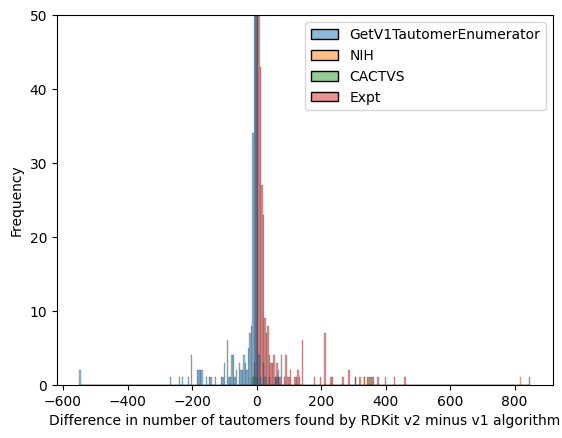

In [64]:
# Plot histogram of n_tauts_diff columns

sns.histplot(n_tauts_diff, bins=300)  # Adjust bins as needed
plt.xlabel('Difference in number of tautomers found by RDKit v2 minus v1 algorithm')
plt.ylabel('Frequency')
# plt.title('Histogram using Seaborn')

largest_y_values = dict()
for source in sources_compare.keys():
    largest_y_values.update({source: second_highest_frequency(n_tauts_diff[source])})

largest_y_value = max(largest_y_values.values())

# plt.ylim(0, largest_y_value * 1.1)
plt.ylim(0, 50)

# Find the frequency at n_tauts_diff = 0
# frequency_at_zero = n_tauts_diff.count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0
# plt.text(0, largest_y_value, f'0 has frequency of {frequency_at_zero}  ', ha='right', va='bottom')

plt.show()


dict_keys(['GetV1TautomerEnumerator', 'Expt'])


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

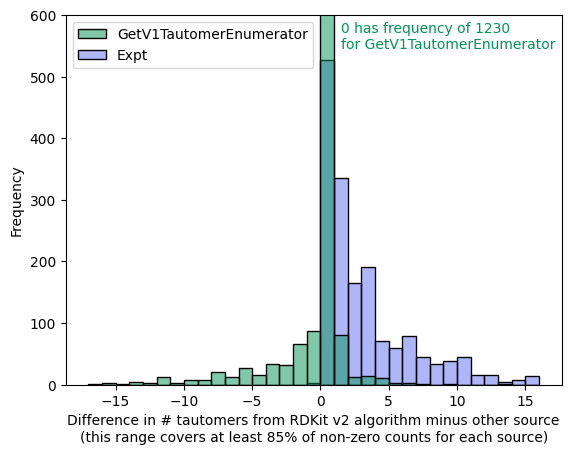

In [65]:
# Plot histogram of n_tauts_diff for sources which have data for all refs

n_tauts_diff_all = {source: n_tauts_diff[source] for source in sources.keys() if sources[source] == "all"}
print(n_tauts_diff_all.keys())
# Set the x bounds (will go from negative to positive of this value)
x_len = 17

# Set the histogram bins so there will be a bin (bar) for each integer value
bins = range(-1 * x_len, x_len, 1)

# Calculate the percent of each data series (excluding delta=0) this plot covers

# Create dictionaries to store values in; keys will be data sources
n_tauts_diff_no_zeros_this_range = dict()
non_zero_counts_this_range = dict()
# for source in sources_compare.keys():
for source in n_tauts_diff_all.keys():
    n_tauts_diff_no_zeros_this_range.update(
        {source: [diff for diff in n_tauts_diff_no_zeros[source] if abs(diff) <= x_len]}
    )
    non_zero_counts_this_range.update(
        {
            source: len(n_tauts_diff_no_zeros_this_range[source])
            / len(n_tauts_diff_no_zeros[source])
        }
    )
non_zero_counts_this_range_min = min(list(non_zero_counts_this_range.values()))

# Set an accessible color palette from https://venngage.com/tools/accessible-color-palette-generator
# colors = ["#5ba300", "#0073e6", "#89ce00", "#b51963"]
colors = [
    "#029356",
    # "#009eb0",
    # "#0073e6",
    "#606ff3",
    # "#9b8bf4",
    ]
sns.set_palette(sns.color_palette(colors))

# Create the histogram plot
sns.histplot(n_tauts_diff_all, bins=bins)

plt.ylabel("Frequency")
xlabel = "Difference in # tautomers from RDKit v2 algorithm minus other source"
xlabel += f"\n(this range covers at least {non_zero_counts_this_range_min:.0%} of non-zero counts for each source)"
plt.xlabel(xlabel)

# Limit the max y to avoid making smaller y values too hard to discern
plt.ylim(0, 600)

# Because this max y cuts off the y value for GetV1TautomerEnumerator at delta = 0, show the value as a label

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff["GetV1TautomerEnumerator"].count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0 for GetV1TautomerEnumerator
plt.text(
    1.5,
    max(plt.ylim()) * 0.9,
    f"0 has frequency of {frequency_at_zero}\nfor GetV1TautomerEnumerator",
    ha="left",
    va="bottom",
    color=colors[0],
)

plt.show()

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

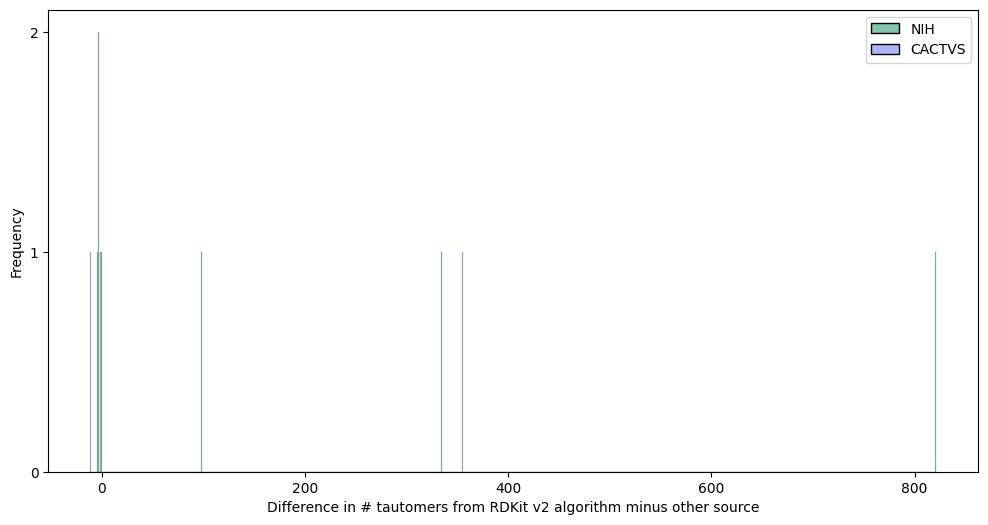

In [66]:
# Plot histogram of n_tauts_diff for sources which do not have data for all refs, because each molecule is run manually
n_tauts_diff_manual = {source: n_tauts_diff[source] for source in sources.keys() if sources[source] == "manual"}

# Set the histogram bins so there will be a bin (bar) for each integer value
combined_set = set(item for sublist in n_tauts_diff_manual.values() for item in sublist)
x_min, x_max = min(combined_set), max(combined_set)

bins = range(x_min, x_max+1, 1)

colors = [
    # "#029356",
    "#009eb0",
    # "#0073e6",
    # "#606ff3",
    "#9b8bf4",
    ]

plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
sns.histplot(n_tauts_diff_manual, bins=bins)
sns.set_palette(sns.color_palette(colors))

# Set the x bounds (will go from negative to positive of this value)

plt.ylabel("Frequency")
xlabel = f"Difference in # tautomers from RDKit v2 algorithm minus other source"
plt.xlabel(xlabel)

# Get the current axis from the plot
ax = plt.gca()

# Set y-axis ticks to be at only integer values
ax.yaxis.set_major_locator(MultipleLocator(1))

plt.show()

In [67]:
def align_ordered_iterables(
        ordered_iterable1: list|tuple,
        ordered_iterable2: list|tuple,
        filler = "",
) -> Iterable:
    """Align the second ordered iterable under the first (in columns), using the filler for items in list1 not in list2, 
    for example:
    
    input:
    list1: a,  c,  b
    list2: a,  f,  c,  e,  d

    output:
    list2: a,  c, "",  f,  e,  d

    Note that no other ordering is applied to either input iterable, 
    and items in the second which are not in the first will be kept in their input order.
    If you want them to be ordered in some way, for example alphabetically, order them before calling this function.

    :param list1: Template list
    :param list2: List to be aligned under the template list
    :param filler: The filler entry to use to provide an "empty" column to align list2 under list1; default is empty string but can be a number or anything else
    :returns: Aligned list2 such that its entries will line up under the same values in list1, or be placed to the right if they are not in list1
    """
    # If either list has no elements, return the initial ordered_iterable2
    if any([len(ordered_iterable1)==0, len(ordered_iterable2)==0]):
        return ordered_iterable2   
    
    # Determine index for each element in ordered_iterable2:
    ordered_iterable2_indices = []
    ordered_iterable2_index_max = len(ordered_iterable1) - 1
    for ordered_iterable2_item in ordered_iterable2:
        try:
            ordered_iterable2_index = ordered_iterable1.index(ordered_iterable2_item)
        # If item from input 2 isn't in input 1, append item to the (growing) index list
        except ValueError:
            ordered_iterable2_index_max += 1
            ordered_iterable2_index = ordered_iterable2_index_max
        # If get an AttributeError, tell user that have a bad data type
        except AttributeError:
            raise AttributeError(f"The first iterable input must be a list or tuple, not a set or dictionary; it is {ordered_iterable1}, which is a {type(ordered_iterable1).__name__}")
        ordered_iterable2_indices.append(ordered_iterable2_index)

    # Create "empty" (all filler) ordered_iterable2 aligned--may be longer than ordered_iterable2 due to blank spaces
    ordered_iterable2_aligned = [filler] * (max(ordered_iterable2_indices) + 1)

    # Slot in items from ordered_iterable2 to overwrite filler entries
    for i, ordered_iterable2_col in enumerate(ordered_iterable2_indices):
        try:
            ordered_iterable2_aligned[ordered_iterable2_col] = ordered_iterable2[i]
        except (TypeError, KeyError):
                raise TypeError(f"The second iterable input must be a list or tuple, not a set or dictionary; it is {ordered_iterable2}, which is a {type(ordered_iterable2).__name__}")

    return ordered_iterable2_aligned

In [68]:
df_melted_aggregated_different.filter(pl.col("Ref").is_in([1704, 1512, 890]))

Ref,mol,flat_tautsExpt,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsCACTVS,flat_tautsNIH,n_tautsExpt,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsCACTVS,n_tautsNIH,tauts_sameGetV1TautomerEnumerator,n_tauts_diffGetV1TautomerEnumerator,tauts_sameNIH,n_tauts_diffNIH,tauts_sameCACTVS,n_tauts_diffCACTVS,tauts_sameExpt,n_tauts_diffExpt
i64,list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],list[str],i64,i64,i64,i64,i64,bool,i64,bool,i64,bool,i64,bool,i64
890,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""COc1c(C[C@@H](C)OC(=O)c2ccccc2)c2c3c(C[C@H](C)OC(=O)c4ccc(O)cc4)c(OC)c(=O)c4c(O)cc(OC)c(c5c(OC)cc(O)c(c1=O)c52)c43"", ""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54""]","[[""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c(O)cc(OC)c5c1c23)C(=O)C(OC)C4=C[C@H](C)OC(=O)c1ccc(O)cc1"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c(c(O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c32)C(=O)C=C1OC""], [""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c3C(C[C@@H](C)OC(=O)c3ccccc3)=C(OC)C(=O)C=2C(=O)CC=1OC"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@@H](C)OC(=O)c3ccccc3)c3c4c5c(c(O)cc(OC)c5c1c23)C(=O)C(OC)C4=C[C@H](C)OC(=O)c1ccc(O)cc1"", … ""COC1=CC(=O)C2C(=O)C(OC)C(=C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c2c(c(O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c32)C(=O)C=C1OC""]]","[[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)C3C=CC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21"", … ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""], [""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)C3C=CC(=O)C=C3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21"", … ""COC1=CC(=O)c2c(O)c(OC)c(C[C@H](C)OC(=O)c3ccc(O)cc3)c3c2c1c1c(OC)cc(O)c2c(O)c(OC)c(=C[C@@H](C)OC(=O)c4ccccc4)c3c21""]]","[[""COC3C(C[C@@H](C)OC(=O)C1CCCCC1)C4C6C(C[C@H](C)OC(=O)C2CCC(O)CC2)C(OC)C(=O)C7C(O)CC(OC)C(C5C(OC)CC(O)C(C3=O)C45)C67""], [""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67"", ""COC2C(O)C4C(=O)CC(OC)C5C6C(OC)CC(=C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67)O"", … ""COC2C(O)C4=C(O)CC(OC)C5C6C(OC)C=C(O)C7C(O)C(OC)C(C[C@H](C)OC(=O)C1CCC(O)CC1)C(C(C2C[C@@H](C)OC(=O)C3CCCCC3)C45)C67""]]","[[""COC1CC(O)C2C(=O)C(OC)C(C[C@@H](C)OC(=O)C3CCCCC3)C3C4C(C[C@H](C)OC(=O)C5CCC(O)CC5)C(OC)C(=O)C5C(O)CC(OC)C(C1C23)C54""], [""COC1CC(O)=C2C(O)C(OC)C(C[C@@H](C)OC(=O)C3CCCCC3)C3C2C1C1C(OC)CC(O)=C2C(O)C(OC)C(C[C@H](C)OC(=O)C4CCC(O)CC4)C3C21"", ""COC1C=C(O)C2C(O)C(OC)C(C[C@@H](C)OC(=O)C3CCCCC3)C3C4C(C[C@H](C)OC(=O)C5CCC(O)CC5)C(OC)C(O)C5C(=O)CC(OC)C(C1C23)C54"", … ""COC1CC(O)=C2C(O)C(OC)C(C[C@H](C)OC(=O)C3CCC(O)CC3)C3C2C1C1C(OC)CC(=O)C2C(O)C(OC)C(C[C@@H](C)OC(=O)C4CCCCC4)C3C21""]]","[[""COC1=C(C[C@H](C)OC(=O)c2ccc(O)cc2)c2c3c(c(O)cc(OC)c3c3c(OC)cc(O)c4c(O)c(OC)c(=C[C@@H](C)OC(=O)c5ccccc5)c2c43)C1=O"", ""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c(=C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1=C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", … ""COC1=CC(=O)C2C(=O)C(OC)=C(C[C@@H](C)OC(=O)c3ccccc3)c3c2c1c1c(OC)cc(O)c2c1c3C(C[C@H](C)OC(=O)c1ccc(O)cc1)=C(OC)C2=O""], [""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c(C[C@H](C)OC(=O)c6ccc(O)cc6)c(c(c1C[C@@H](C)OC(=O)c1ccccc1)c23)c54"", ""COC1=c2c3c(c(=O)c(OC)c(C[C@@H](C)OC(=O)c4ccccc4)c3

In [69]:
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 73)
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1704) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1688) # Bad--weird structure drawing
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1689) # Bad--weird structure drawing
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 890) # Asked Marc Nicklaus to generate CACTVS tautomers for
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1758) # Bad--weird structure drawing
# df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 1512) # Asked Marc Nicklaus to generate CACTVS tautomers for
df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 457)
df_melted_aggregated_different_example

Ref,mol,flat_tautsExpt,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautCACTVS,tautsCACTVS,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsCACTVS,flat_tautsNIH,n_tautsExpt,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsCACTVS,n_tautsNIH,tauts_sameGetV1TautomerEnumerator,n_tauts_diffGetV1TautomerEnumerator,tauts_sameNIH,n_tauts_diffNIH,tauts_sameCACTVS,n_tauts_diffCACTVS,tauts_sameExpt,n_tauts_diffExpt
i64,list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],list[str],i64,i64,i64,i64,i64,bool,i64,bool,i64,bool,i64,bool,i64
457,"[<rdkit.Chem.rdchem.Mol object at 0x179c83300>, <rdkit.Chem.rdchem.Mol object at 0x179cd7370>]","[""[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(=O)c-3c(O[2H])c2O[2H])cc1O[2H]"", ""[2H]Oc1ccc(-c2oc3c([2H])c(O[2H])c(OC)c(O[2H])c3c(=O)c2O[2H])cc1O[2H]""]","[[""[2H]OC1=CC(=C2OC3=C(C(=O)C(OC)C([OH][2H])=C3[2H])C([OH][2H])=C2O[2H])C=CC1=O[2H]"", ""[2H]OC1=C([OH][2H])C2=C(OC1=C1C=CC(=O[2H])C(=O[2H])C1)C([2H])C(=O[2H])C(OC)C2=O"", … ""[2H]OC1=CC(C2OC3=C([2H])C(=O[2H])C(OC)C(=O)C3=C(O[2H])C2=O[2H])C=CC1=O[2H]""], [""[2H]OC1=C(O)C2=C(OC1=C1C=CC(=O[2H])C(=O[2H])C1)C([2H])=C([OH][2H])C(OC)C2=O[2H]"", ""[2H]O=C1C=C(C2OC3=C([2H])C(=O[2H])C(OC)C(=O[2H])C3=C(O)C2=O[2H])CCC1=O[2H]"", … ""[2H]OC1=C2C(=O)C(=O[2H])C(C3=CC(=O[2H])C(=O[2H])CC3)OC2=C([2H])C(=O[2H])C1OC""]]","[[""[2H]Oc1c([OH][2H])c(-c2ccc([OH][2H])c([OH][2H])c2)oc2c([2H])c([OH][2H])c(OC)c(=O)c1-2"", ""[2H]OC1=CC(=C2OC3=C(C(=O)C(OC)C([OH][2H])=C3[2H])C([OH][2H])=C2O[2H])C=CC1=O[2H]"", … ""[2H]OC1C(=O[2H])C(C2=CC(=O[2H])C(=O[2H])C=C2)Oc2c([2H])c([OH][2H])c(OC)c(O)c21""], [""[2H]OC1=C(O)C2=C(OC1=C1C=CC(=O[2H])C(=O[2H])C1)C([2H])=C([OH][2H])C(OC)C2=O[2H]"", ""[2H]O=C1C=C(C2OC3=C([2H])C(=O[2H])C(OC)C(=O[2H])C3=C(O)C2=O[2H])CCC1=O[2H]"", … ""[2H]OC1=C(c2ccc([OH][2H])c(O[2H])c2)OC2=C([2H])C([OH][2H])=C(OC)C(=O[2H])C2C1=O""]]","[null, null]","[[], []]","[[""[2H]OC1=C(c2ccc(O[2H])c(O[2H])c2)OC2=C([2H])C(=O)C([2H])(OC)C(=O)C2([2H])C1=O"", ""[2H]OC1=CC(=C2Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(O[2H])=C2O[2H])C=CC1=O"", … ""[2H]OC1=C2C(=O)C([2H])(OC)C(=O)C([2H])=C2OC(c2ccc(O[2H])c(O[2H])c2)=C1O[2H]""], [""[2H]OC1=C(OC)C(=O)C([2H])([2H])c2oc(-c3ccc(O[2H])c(O[2H])c3)c(O[2H])c(=O)c21"", ""[2H]OC1=C([2H])c2oc(-c3ccc(O[2H])c(O[2H])c3)c(O[2H])c(=O)c2C(=O)C1([2H])OC"", … ""[2H]Oc1ccc(C2([2H])Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(=O)C2=O)cc1O[2H]""]]","[""[2H]OC1=C(O)C2=C(OC1=C1C=CC(=O[2H])C(=O[2H])C1)C([2H])=C([OH][2H])C(OC)C2=O[2H]"", ""[2H]OC1=CC(=C2OC3=C(C(=O)C(OC)C([OH][2H])=C3[2H])C([OH][2H])=C2O[2H])C=CC1=O[2H]"", … ""[2H]OC1=C2C(=O)C(=O[2H])C(C3=CC(=O[2H])C(=O[2H])CC3)OC2=C([2H])C(=O[2H])C1OC""]","[""[2H]Oc1c([OH][2H])c(-c2ccc([OH][2H])c([OH][2H])c2)oc2c([2H])c([OH][2H])c(OC)c(=O)c1-2"", ""[2H]OC1=C(O)C2=C(OC1=C1C=CC(=O[2H])C(=O[2H])C1)C([2H])=C([OH][2H])C(OC)C2=O[2H]"", … ""[2H]OC1C(=O[2H])C(C2=CC(=O[2H])C(=O[2H])C=C2)Oc2c([2H])c([OH][2H])c(OC)c(O)c21""]",[],"[""[2H]OC1=C([2H])c2oc(-c3ccc(O[2H])c(O[2H])c3)c(O[2H])c(=O)c2C(=O)C1([2H])OC"", ""[2H]OC1=CC(c2oc3c([2H])c(=O)c(OC)c(O[2H])c-3c(O[2H])c2O[2H])=CC([2H])C1=O"", … ""[2H]Oc1ccc(C2([2H])Oc3c([2H])c(O[2H])c(OC)c(O[2H])c3C(=O)C2=O)cc1O[2H]""]",2,851,873,0,30,false,-22,false,821,false,null,false,849


In [70]:
# Output SMILES for all RDKit V2 tautomers for a ref
# tauts_890_rdkitv2 = df_melted_aggregated_different_example[0]["flat_tautsTautomerEnumerator"].item().to_list()
# import csv

# filename = "../data/ref890_rdkit_v2_tautomers.csv"

# # Open the file in write mode
# with open(filename, 'w', newline='') as csvfile:
#     # Create a CSV writer object
#     csvwriter = csv.writer(csvfile)

#     # Write each item of the list on its own line
#     csvwriter.writerows([[item] for item in tauts_890_rdkitv2])


In [110]:
# For the various data sources, extract SMILES, align them sequentially, and create RDKit molecules for drawing 
smls_expt = df_melted_aggregated_different_example.select("flat_tautsExpt").item().to_list()
smls_v2 = df_melted_aggregated_different_example.select("flat_tautsTautomerEnumerator").item().to_list()
smls_v2_aligned = align_ordered_iterables(smls_expt, smls_v2)
smls_v1 = df_melted_aggregated_different_example.select("flat_tautsGetV1TautomerEnumerator").item().to_list()
smls_v1_aligned = align_ordered_iterables(smls_v2_aligned, smls_v1)
smls_nih = df_melted_aggregated_different_example.select("flat_tautsNIH").item().to_list()
smls_nih_aligned = align_ordered_iterables(smls_v1_aligned, smls_nih)
smls_cactvs = df_melted_aggregated_different_example.select("flat_tautsCACTVS").item().to_list()
smls_cactvs_aligned = align_ordered_iterables(smls_nih_aligned, smls_cactvs)

tauts_expt = [mol_from_sml(sml) for sml in smls_expt]
tauts_v2_aligned = [mol_from_sml(sml) if sml else None for sml in smls_v2_aligned]
tauts_v1_aligned = [mol_from_sml(sml) if sml else None for sml in smls_v1_aligned]
tauts_nih_aligned = [mol_from_sml(sml) if sml else None for sml in smls_nih_aligned]
tauts_cactvs_aligned = [mol_from_sml(sml) if sml else None for sml in smls_cactvs_aligned]

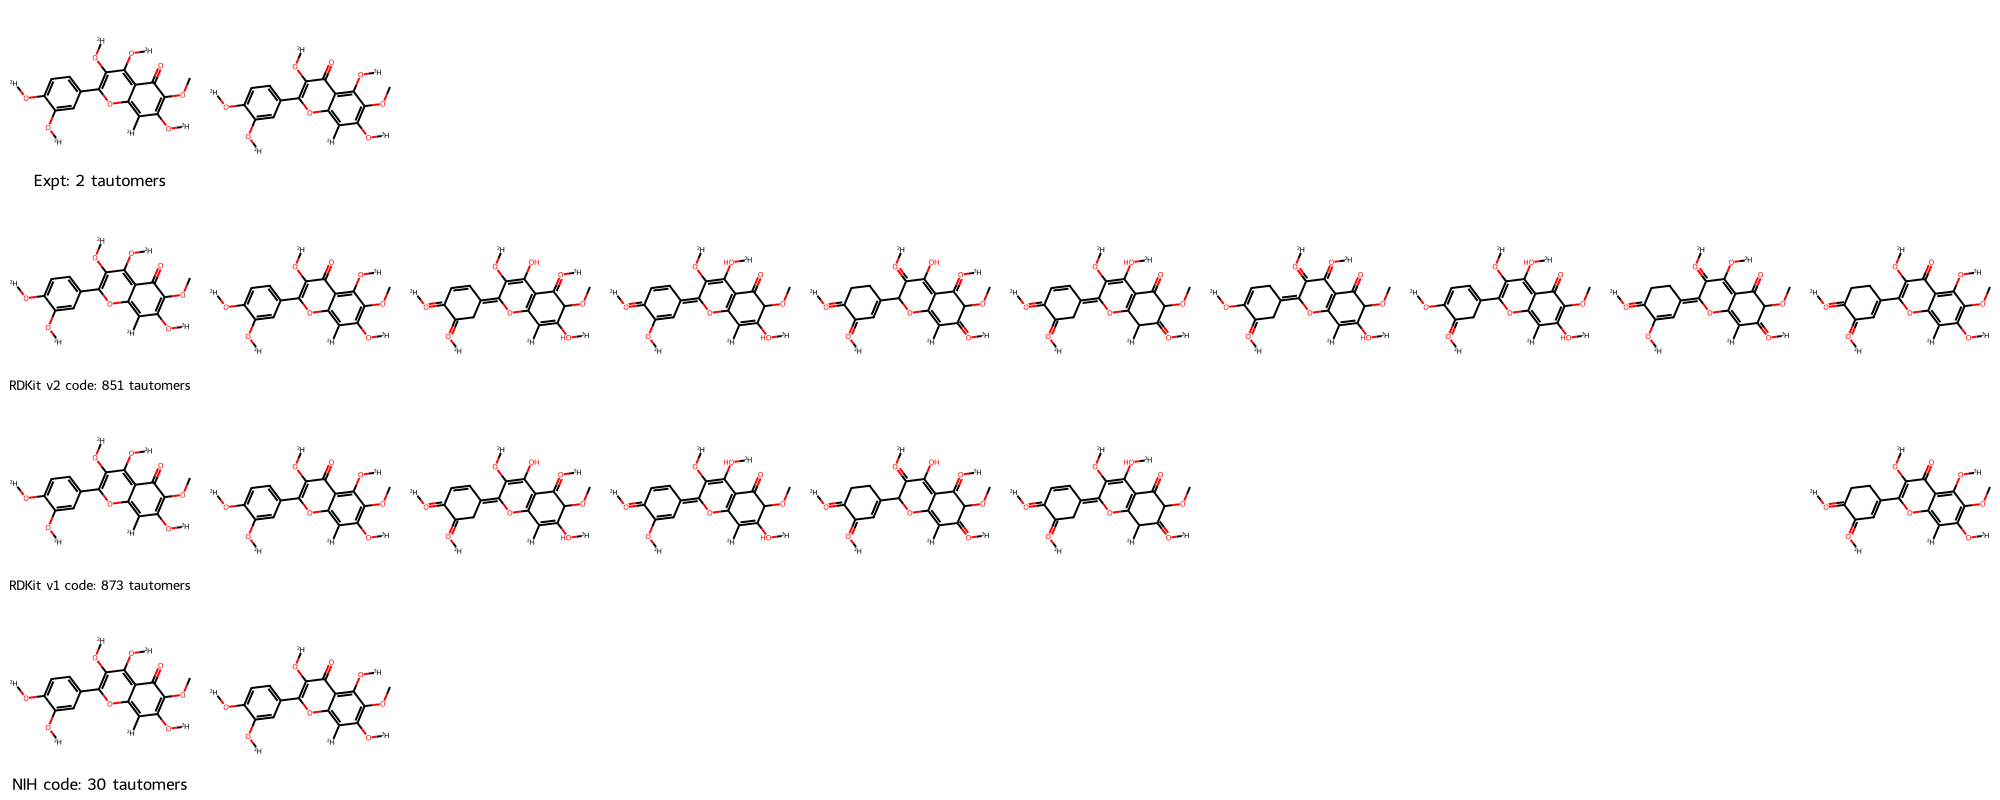

In [117]:
# Plot all sets of tautomers

# Limit number of columns so structures will be readable
max_cols = 10
# Create nested (2D) data structures for Draw.MolsMatrixToGridImage
smls_matrix = [
    smls_expt,
    smls_v2_aligned,
    smls_v1_aligned,
]
tauts_matrix = [
    tauts_expt[:max_cols],
    tauts_v2_aligned[:max_cols],
    tauts_v1_aligned[:max_cols],
]

row_labels = [
    f"Expt: {len(smls_expt)} tautomers",
    f"RDKit v2 code: {len(smls_v2)} tautomers",
    f"RDKit v1 code: {len(smls_v1)} tautomers",
]

# If NIH tautomers generated, add row for them
if len(smls_nih):
    smls_matrix.append(smls_nih_aligned)
    tauts_matrix.append(tauts_nih_aligned[:max_cols])
    row_labels.append(f"NIH code: {len(smls_nih)} tautomers")

# If CACTVS tautomers generated, add row for them
if len(smls_cactvs):
    smls_matrix.append(smls_cactvs)
    tauts_matrix.append(tauts_cactvs_aligned[:max_cols])
    row_labels.append(f"CACTVS code: {len(smls_cactvs)} tautomers")

# Initialize a legends matrix with empty strings
legends_matrix = [["" for item in row] for row in tauts_matrix]

# Label first molecule in each row with source and number of tautomers

for label_index, row_label in enumerate(row_labels):
        legends_matrix[label_index][0] = row_label

# Align structures based on maximum common substructure (mcs)
# Exclude blank entries to avoid problem with aligning empty molecules
tauts_all_flat = [
    item for sublist in tauts_matrix for item in sublist if item is not None
]
mcs = rdFMCS.FindMCS(
    tauts_all_flat,
    bondCompare=rdFMCS.BondCompare.CompareAny,
)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_all_flat:
    Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

Draw.MolsMatrixToGridImage(
    molsMatrix=tauts_matrix, legendsMatrix=legends_matrix, useSVG=True, maxMols=1700
)

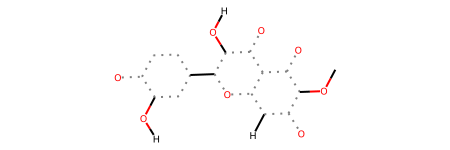

In [73]:
# Show how large, and thus effective, MCS is if use bondCompare=rdFMCS.BondCompare.CompareAny
mcs_mol

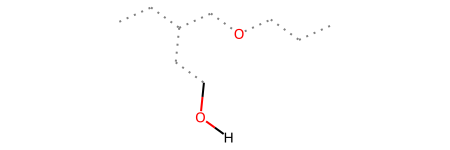

In [74]:
# Show how much smaller, and thus ineffective, MCS is if don't use bondCompare=rdFMCS.BondCompare.CompareAny
mcs_strict = rdFMCS.FindMCS(
    tauts_all_flat,
)
mcs_smarts_strict = mcs_strict.smartsString
mcs_mol_strict = Chem.MolFromSmarts(mcs_smarts_strict)
mcs_mol_strict

In [75]:
# Optional--Checking data quality
df_1 = df.filter(pl.col("Ref")==1).select("Ref","Size",*numbered_columns[:4])
df_1
df_1_InChI = df_1.select("Ref",*InChI_columns[:2])
df_1_InChI = (
    df_1_InChI
    .melt(id_vars="Ref", value_vars=InChI_columns[:2], value_name="InChI")
    .select("InChI")
    .drop_nulls()
)
unique_InChI = set(df_1_InChI["InChI"].to_list())
print(f"{unique_InChI=}")

df_1_smls = df_1.select("Ref",*SMILES_columns[:2])

df_1_smls = (
    df_1_smls
    .melt(id_vars="Ref", value_vars=SMILES_columns[:2], value_name="sml")
    .select("sml")
    .drop_nulls()
)
unique_smls = df_1_smls["sml"].to_list()
unique_mols = [mol_from_sml(sml) for sml in unique_smls]
unique_smls_canon = {Chem.MolToSmiles(mol) for mol in unique_mols}
unique_smls_to_inchi = {Chem.MolToInchi(mol) for mol in unique_mols}

print(f"{unique_smls_canon=}")
print(f"{unique_smls_to_inchi=}")

ColumnNotFoundError: Size

Error originated just after this operation:
DF ["Ref", "SMILES_1", "Std_InChI_1", "SMILES_2"]; PROJECT */11 COLUMNS; SELECTION: "None"

Hi

In [ ]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
smls_tauts

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4eff0>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4ef80>},
 {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4f1b0>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x28ec4fa70>}]

In [ ]:
for i in range(0,1000):
    smls_tauts = enumerate_tauts(sml)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x28ec4f370>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x28ec4f300>}, {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x28ec4fc30>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x29be152a0>}]
[['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1'], ['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1']]
[[<rdkit.Chem.rdchem.Mol object at 0x28ec4f370>, <rdkit.Chem.rdchem.Mol object at 0x28ec4f300>], [<rdkit.Chem.rdchem.Mol object at 0x28ec4fc30>, <rdkit.Chem.rdchem.Mol object at 0x29be152a0>]]


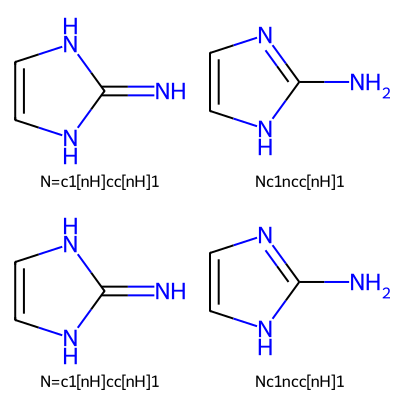

In [ ]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
print(smls_tauts)
smls = [[item for item in enumerator.keys()] for enumerator in smls_tauts]
tauts = [[item for item in enumerator.values()] for enumerator in smls_tauts]

print(smls)
print(tauts)
Draw.MolsMatrixToGridImage(tauts, legendsMatrix=smls)